In [3]:
%pylab inline
import seaborn as sns
sns.set_style('ticks')
sns.set_context('poster', font_scale=2.0)
%config InlineBackend.figure_format = 'retina'

plt.rcParams['figure.figsize'] = (12.8, 9.6)
plt.rcParams['figure.facecolor'] = 'white'


Populating the interactive namespace from numpy and matplotlib


In [4]:
import pickle

In [5]:
from tqdm import tqdm_notebook as tqdm

In [6]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

In [7]:
import scipy

import scipy.constants as sc
hbarc = ( sc.hbar * sc.speed_of_light
         / sc.mega / sc.electron_volt / sc.femto )
ainv = 2.194e3 # lattice cutoff in GeV
lat_unit = hbarc/ainv # lattice spacing in fm

mxi = 0.665 # mass of Xi in lattice unit
mpi = 510/ainv # mass of pion in lattice unit

In [8]:
print(np.__version__)
print(scipy.__version__)
print(sns.__version__)
print(matplotlib.__version__)

1.14.2
1.0.0
0.8.1
2.2.2


# import data

In [113]:
ls ../data/potential

pot_1s0_xixi_L64.pkl                 pot_jk_1s0_xixi_L64_exp.pkl
pot_H0term_jk_1s0_xixi_L64_exp.pkl   pot_jk_1s0_xixi_L64_wall.pkl
pot_H0term_jk_1s0_xixi_L64_wall.pkl


In [9]:
pot_jk_bin = {}
pot_H0_jk_bin = {}
for src in ['wall', 'exp']:
    with open(f'../data/potential/pot_jk_1s0_xixi_L64_{src}.pkl', 'rb') as fin:
        _, rs, pot_jk_bin[src] = pickle.load(fin)
    with open(f'../data/potential/pot_H0term_jk_1s0_xixi_L64_{src}.pkl', 'rb') as fin:
        _, rs, pot_H0_jk_bin[src] = pickle.load(fin)

In [10]:
pot_jk_bin['wall'][13].shape

(20, 6545)

In [11]:
its = list(pot_jk_bin['wall'].keys()) # list of t
bin_num = pot_jk_bin['wall'][its[0]].shape[0] # number of jack-knife samples

# check data

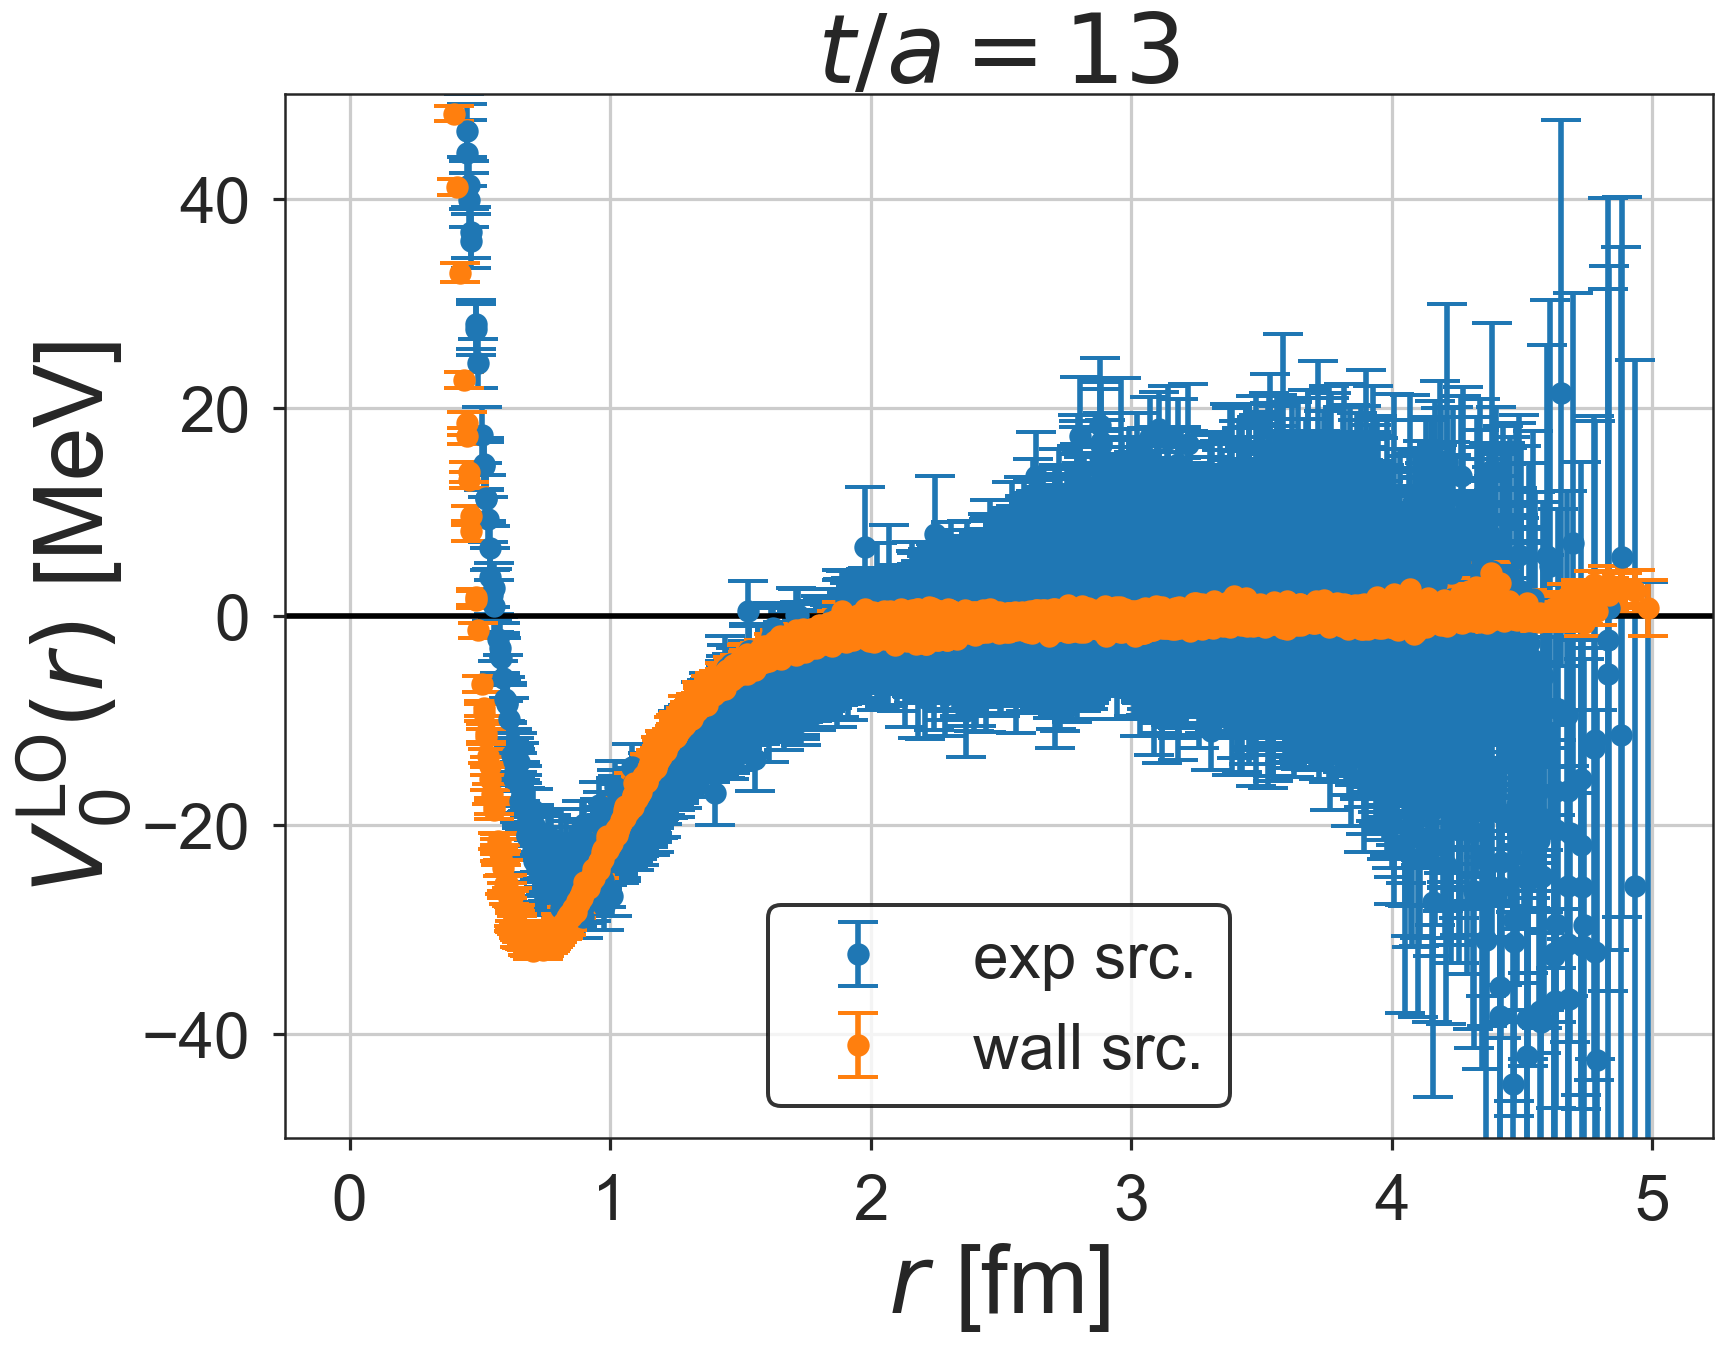

In [12]:
it = 13
fig, ax = plt.subplots()
for src, src_lbl in zip(['exp', 'wall'], ['smeared', 'wall']):
    ys_jk = pot_jk_bin[src][it]
    ax.errorbar(rs*lat_unit, ys_jk.mean(axis=0)*ainv, 
            ys_jk.std(axis=0) * np.sqrt(bin_num - 1)*ainv,
            fmt='o', capsize=10, capthick=2.0, label=f'{src} src.')
ax.set_ylim(-50, 50)
ax.set_title(rf'$t/a = {it}$', size=48)
ax.axhline(0, color='black')
ax.grid()
ax.set_xlabel(r'$r$ [fm]', size=48)
ax.set_ylabel(r'$V_0^\mathrm{LO}(r)$ [MeV]', size=48)
leg = ax.legend(frameon=True)
leg.get_frame().set_edgecolor('black')
leg.get_frame().set_linewidth(2.0)

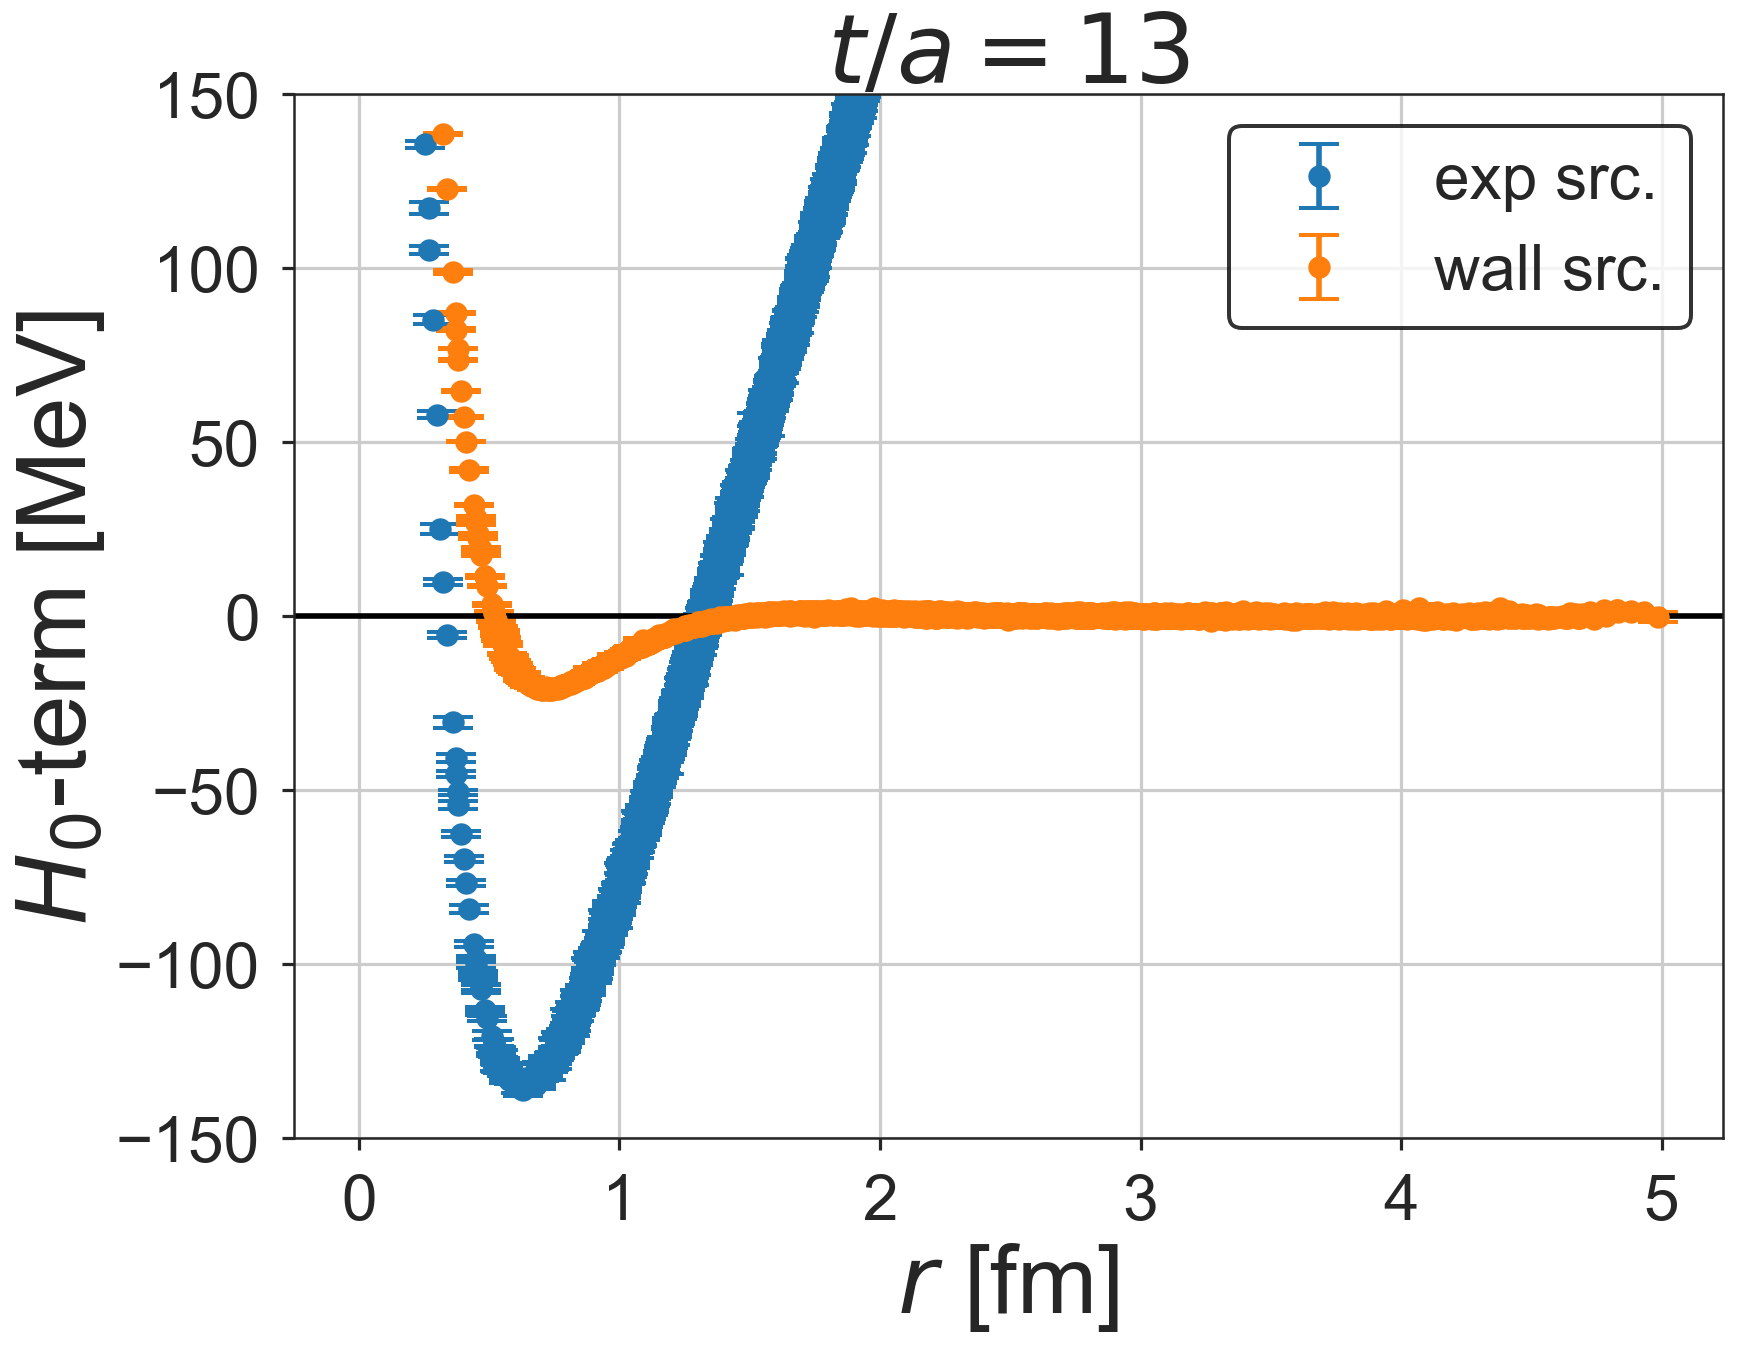

In [13]:
it = 13
fig, ax = plt.subplots()
for src, src_lbl in zip(['exp', 'wall'], ['smeared', 'wall']):
    ys_jk = pot_H0_jk_bin[src][it]
    ax.errorbar(rs*lat_unit, ys_jk.mean(axis=0)*ainv, 
            ys_jk.std(axis=0) * np.sqrt(bin_num - 1)*ainv,
            fmt='o', capsize=10, capthick=2.0, label=f'{src} src.')
ax.set_ylim(-150, 150)
ax.set_title(rf'$t/a = {it}$', size=48)
ax.axhline(0, color='black')
ax.grid()
ax.set_xlabel(r'$r$ [fm]', size=48)
ax.set_ylabel(r'$H_0$-term [MeV]', size=48)
leg = ax.legend(frameon=True)
leg.get_frame().set_edgecolor('black')
leg.get_frame().set_linewidth(2.0)

# decompress data

Only A1 unique points are stored in pickle file.

In [14]:
L = 64
rs_full = np.array([np.sqrt(ix**2 + iy**2 + iz**2)
                    for ix in range(-L//2,L//2)
                    for iy in range(-L//2,L//2)
                    for iz in range(-L//2,L//2)]).reshape(L,L,L)
rs_full = np.roll(rs_full, (L//2,L//2,L//2), axis=(0,1,2)).flatten()


In [15]:
a1_uniq = np.array([ix + L * (iy + L * iz)
                   for ix in range(0, L//2+1)
                   for iy in range(0, ix+1)
                   for iz in range(0, iy+1)])

In [16]:
a1_uniq_ind = {}
ind = 0
for ix in range(0, L//2+1):
    for iy in range(0, ix+1):
        for iz in range(0, iy+1):
            a1_uniq_ind[(ix, iy, iz)] = ind
            ind += 1
xyz_ind = {}
for ix in range(L):
    for iy in range(L):
        for iz in range(L):
            _ind = np.sort([min(ix,L-ix), min(iy,L-iy), min(iz,L-iz)])[::-1]
            xyz_ind[(ix,iy,iz)] = a1_uniq_ind[(_ind[0], _ind[1], _ind[2])]

In [17]:
pot_jk_bin_full = {}
for src in ['wall', 'exp']:
    pot_jk_bin_full[src] = {}
    for it in tqdm(its):
        pot_full = np.zeros((bin_num, L, L, L))
        for ix in range(L):
            for iy in range(L):
                for iz in range(L):
                    pot_full[:,ix,iy,iz] = pot_jk_bin[src][it][:,xyz_ind[(ix,iy,iz)]]
        pot_jk_bin_full[src][it] = pot_full.reshape(bin_num, L**3)

HBox(children=(IntProgress(value=0, max=7), HTML(value='')))

HBox(children=(IntProgress(value=0, max=7), HTML(value='')))

In [18]:
pot_H0_jk_bin_full = {}
for src in ['wall', 'exp']:
    pot_H0_jk_bin_full[src] = {}
    for it in tqdm(its):
        pot_H0_full = np.zeros((bin_num, L, L, L))
        for ix in range(L):
            for iy in range(L):
                for iz in range(L):
                    pot_H0_full[:,ix,iy,iz] = pot_H0_jk_bin[src][it][:,xyz_ind[(ix,iy,iz)]]
        pot_H0_jk_bin_full[src][it] = pot_H0_full.reshape(bin_num, L**3)

HBox(children=(IntProgress(value=0, max=7), HTML(value='')))

HBox(children=(IntProgress(value=0, max=7), HTML(value='')))

# diff of potentials

In [19]:
dV_LO_jk = {}
dLapR_jk = {}
for it in its:
    dV_LO_jk[it] = pot_jk_bin_full['wall'][it] - pot_jk_bin_full['exp'][it]
    dLapR_jk[it] = mxi * (pot_H0_jk_bin_full['wall'][it] - pot_H0_jk_bin_full['exp'][it])

[-0.52491935  0.07894606  2.29100185 -0.10993918  0.22161887  7.05704236]


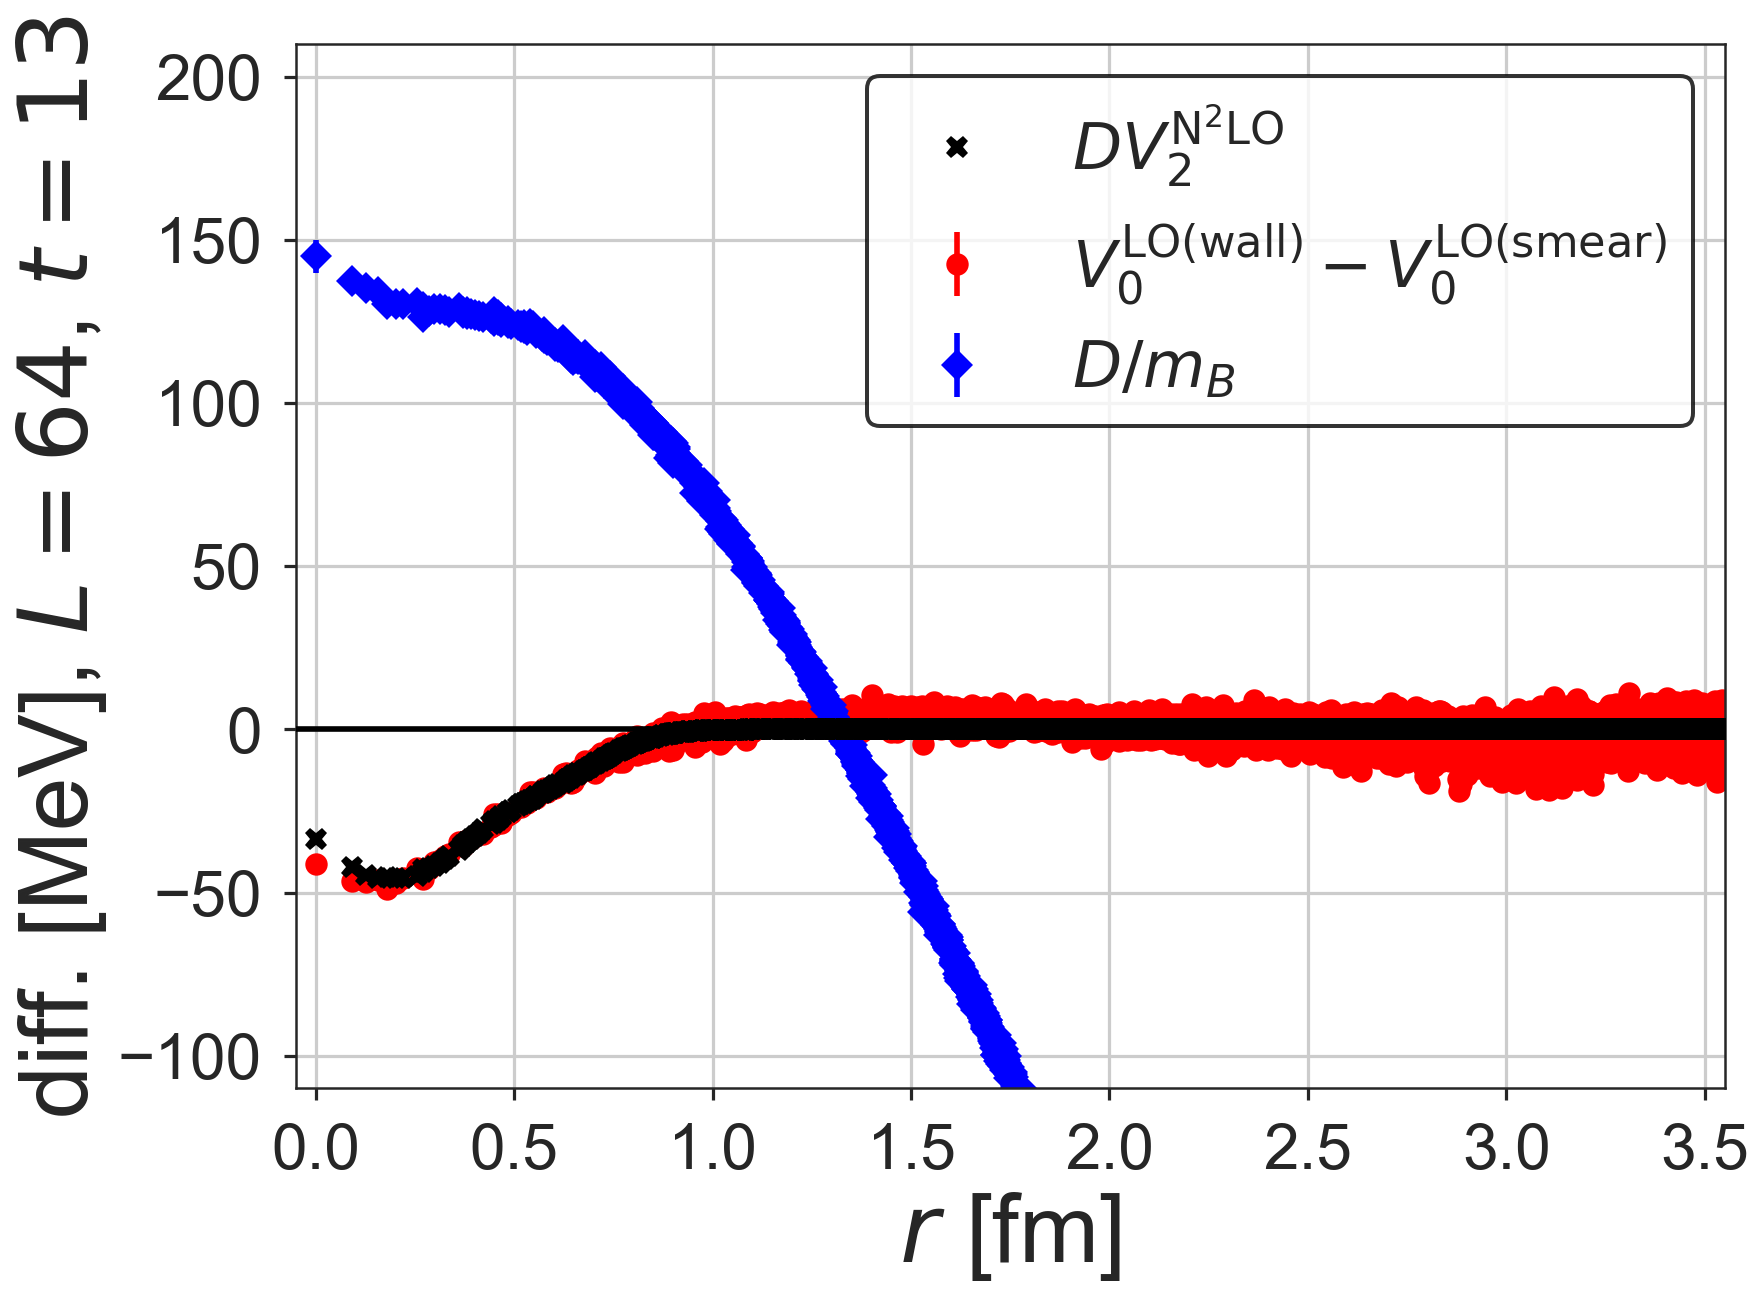

In [20]:
it = 13
fig, ax = plt.subplots()

ax.errorbar(rs * lat_unit, dV_LO_jk[it].mean(axis=0)[a1_uniq] * ainv,
            dV_LO_jk[it].std(axis=0)[a1_uniq] * np.sqrt(bin_num - 1),
           fmt='o', color='red', label=r'$V_0^\mathrm{LO(wall)} - V_0^\mathrm{LO(smear)}$')
ax.errorbar(rs * lat_unit, dLapR_jk[it].mean(axis=0)[a1_uniq]/mxi * ainv,
            dLapR_jk[it].std(axis=0)[a1_uniq] * np.sqrt(bin_num - 1)/mxi * ainv,
            fmt='D', color='blue',
            label=r'$D/m_B$')
# fitting
p0 = np.array([-4.9e-1, 1.1e-1, 2.6e0, -1.5e-1, 2.0e-1, 6.8e0])
pot_2gauss = lambda p, x: p[0]*np.exp(-p[1]*(x-p[2])**2) + p[3]*np.exp(-p[4]*(x-p[5])**2)
errf = lambda p, y, x, dfac, err: (dfac * pot_2gauss(p, x) - y)/err
fitr = (0, 30) 
mask = (rs_full >= fitr[0]) & (rs_full <= fitr[1])
pfit = scipy.optimize.leastsq(errf, p0, args=(dV_LO_jk[it].mean(axis=0)[mask],
                                             rs_full[mask], dLapR_jk[it].mean(axis=0)[mask],
                                             dV_LO_jk[it].std(axis=0)[mask]*np.sqrt(bin_num-1)),
                             full_output=True)
print(pfit[0])
ax.plot(rs*lat_unit, dLapR_jk[it].mean(axis=0)[a1_uniq] * pot_2gauss(pfit[0], rs) * ainv, 'X', color='black',
       label=r'$D V_2^\mathrm{N^2LO}$', zorder=5)

ax.set_xlim(-0.05,3.55)
ax.set_xticks([0,0.5,1.0,1.5, 2.0, 2.5, 3.0, 3.5])
ax.set_ylim(-110, 210)
ax.set_xlabel(r'$r$ [fm]', fontsize=48)
ax.set_ylabel(r'diff. [MeV], $L=64$, $t = {}$'.format(it), fontsize=48)
ax.grid()
ax.axhline(0, color='black', zorder=3)
leg = ax.legend(frameon=True)
leg.get_frame().set_edgecolor('black')
leg.get_frame().set_linewidth(2.0)

# N2LO potential

In [21]:
def calc_N2LO_pot_jk(ibin, err, it, fitr=(0, 30)):
    p0 = np.array([-4.9e-1, 1.1e-1, 2.6e0, -1.5e-1, 2.0e-1, 6.8e0])
    pot_2gauss = lambda p, x: p[0]*np.exp(-p[1]*(x-p[2])**2) + p[3]*np.exp(-p[4]*(x-p[5])**2)
    errf = lambda p, y, x, dfac, err: (dfac * pot_2gauss(p, x) - y)/err
    mask = (rs_full >= fitr[0]) & (rs_full <= fitr[1])
    
    pfit = scipy.optimize.leastsq(errf, p0,
                                 args=(dV_LO_jk[it][ibin,mask], rs_full[mask],
                                       dLapR_jk[it][ibin,mask], err[mask]),
                                  full_output=True)
    V2 = pot_2gauss(pfit[0], rs_full)
    V0 = pot_jk_bin_full['wall'][it][ibin,:] - V2 *  mxi * pot_H0_jk_bin_full['wall'][it][ibin,:]
    return V0, V2

In [22]:
V0_N2LO_jk = {}
V2_N2LO_jk = {}
for it in [13, 14, 15, 16]:
    diff_err = dV_LO_jk[it].std(axis=0) * np.sqrt(bin_num - 1)
    v0_list = []
    v2_list = []
    for ibin in tqdm(range(bin_num)):
        v0, v2 = calc_N2LO_pot_jk(ibin, diff_err, it=it)
        v0_list.append(v0)
        v2_list.append(v2)
        
    V0_N2LO_jk[it] = np.array(v0_list)
    V2_N2LO_jk[it] = np.array(v2_list)
    

HBox(children=(IntProgress(value=0, max=20), HTML(value='')))

HBox(children=(IntProgress(value=0, max=20), HTML(value='')))

HBox(children=(IntProgress(value=0, max=20), HTML(value='')))

HBox(children=(IntProgress(value=0, max=20), HTML(value='')))

In [36]:
mkdir pkls

In [41]:
v0_n2lo_jk_pkl = {}
v2_n2lo_jk_pkl = {}
for it in [13, 14, 15, 16]:
    v0_n2lo_jk_pkl[it] = V0_N2LO_jk[it][:,a1_uniq]
    v2_n2lo_jk_pkl[it] = V2_N2LO_jk[it][:,a1_uniq]
with open('pkls/n2lo_pot_jk.pkl', 'wb') as fout:
    pickle.dump((rs, v0_n2lo_jk_pkl, v2_n2lo_jk_pkl), fout)

In [37]:
V0_N2LO_jk[13].shape

(20, 262144)

In [23]:
pot_jk_bin['wall'][13].shape

(20, 6545)

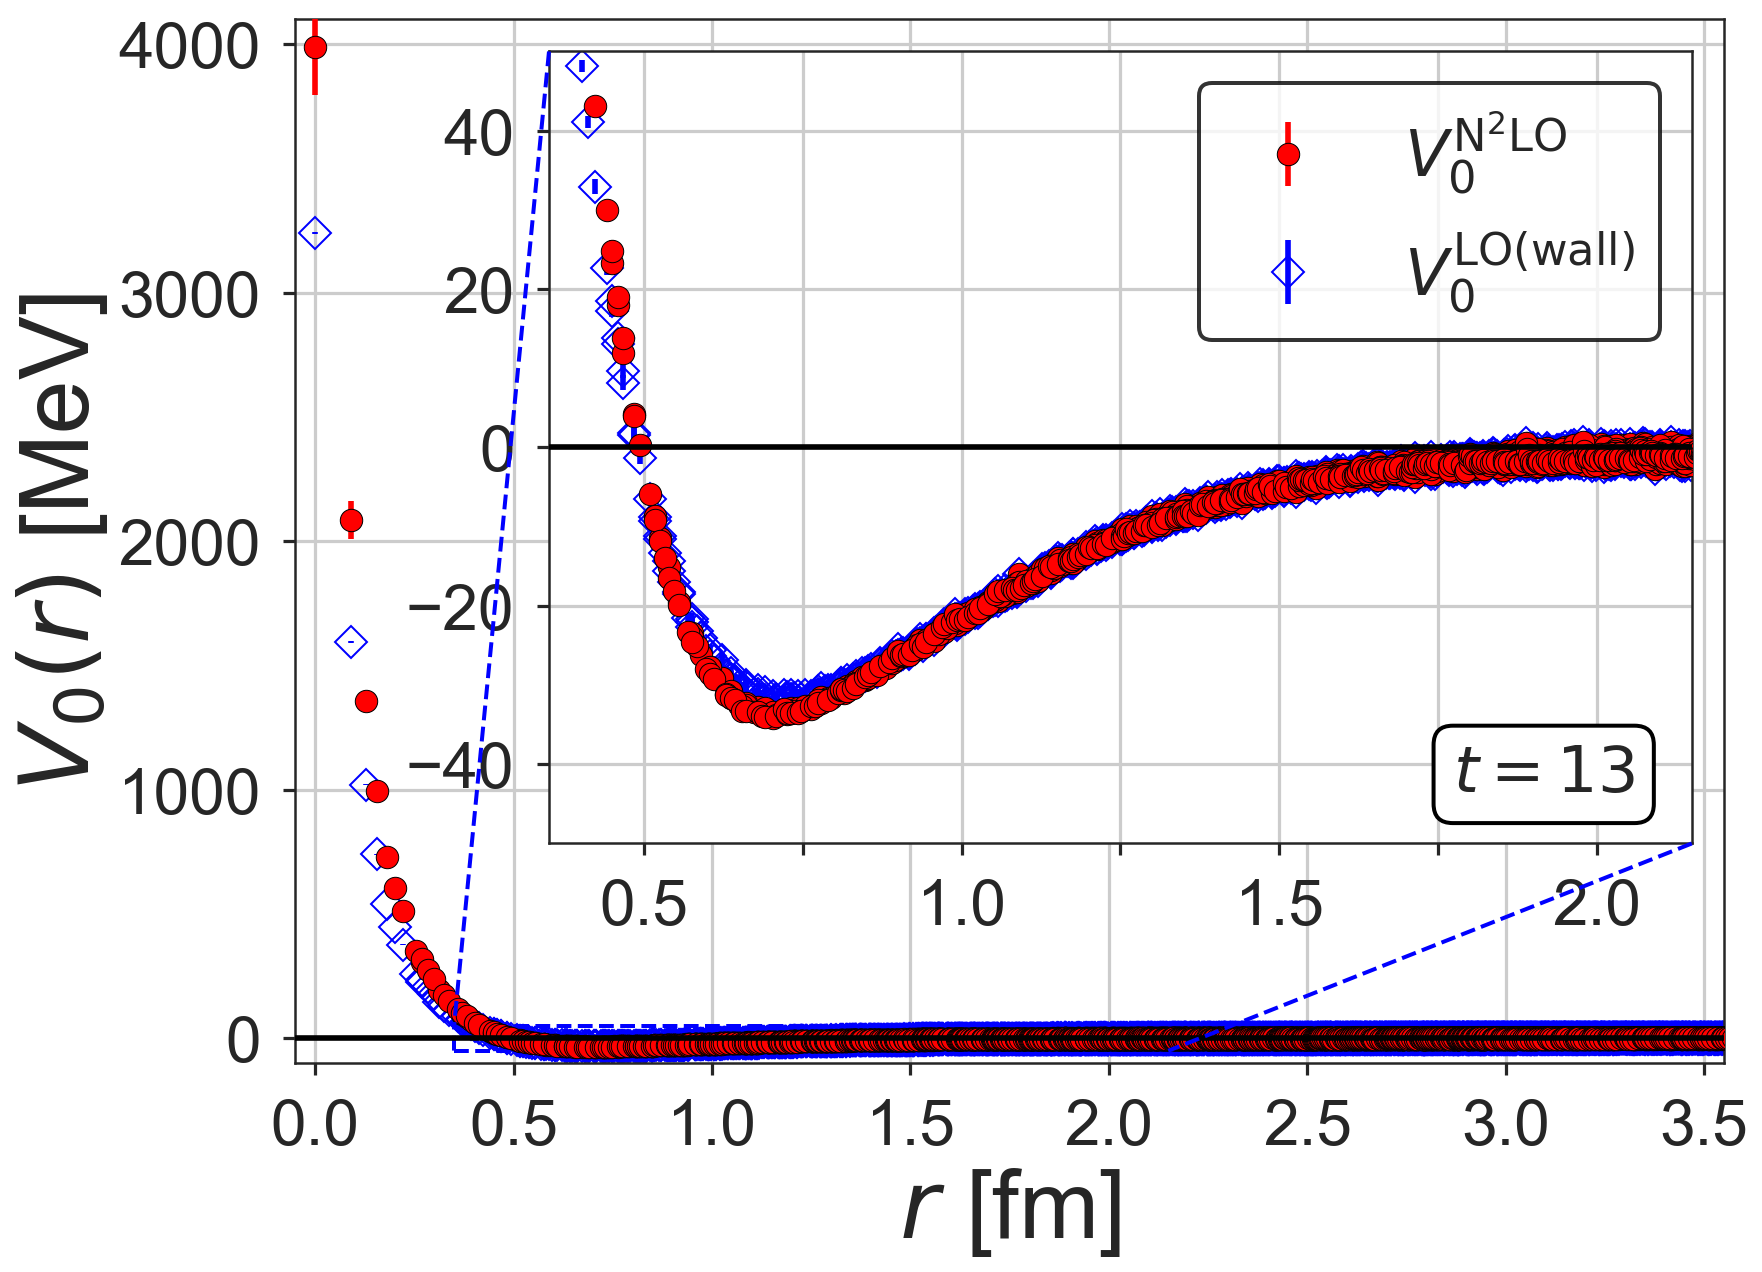

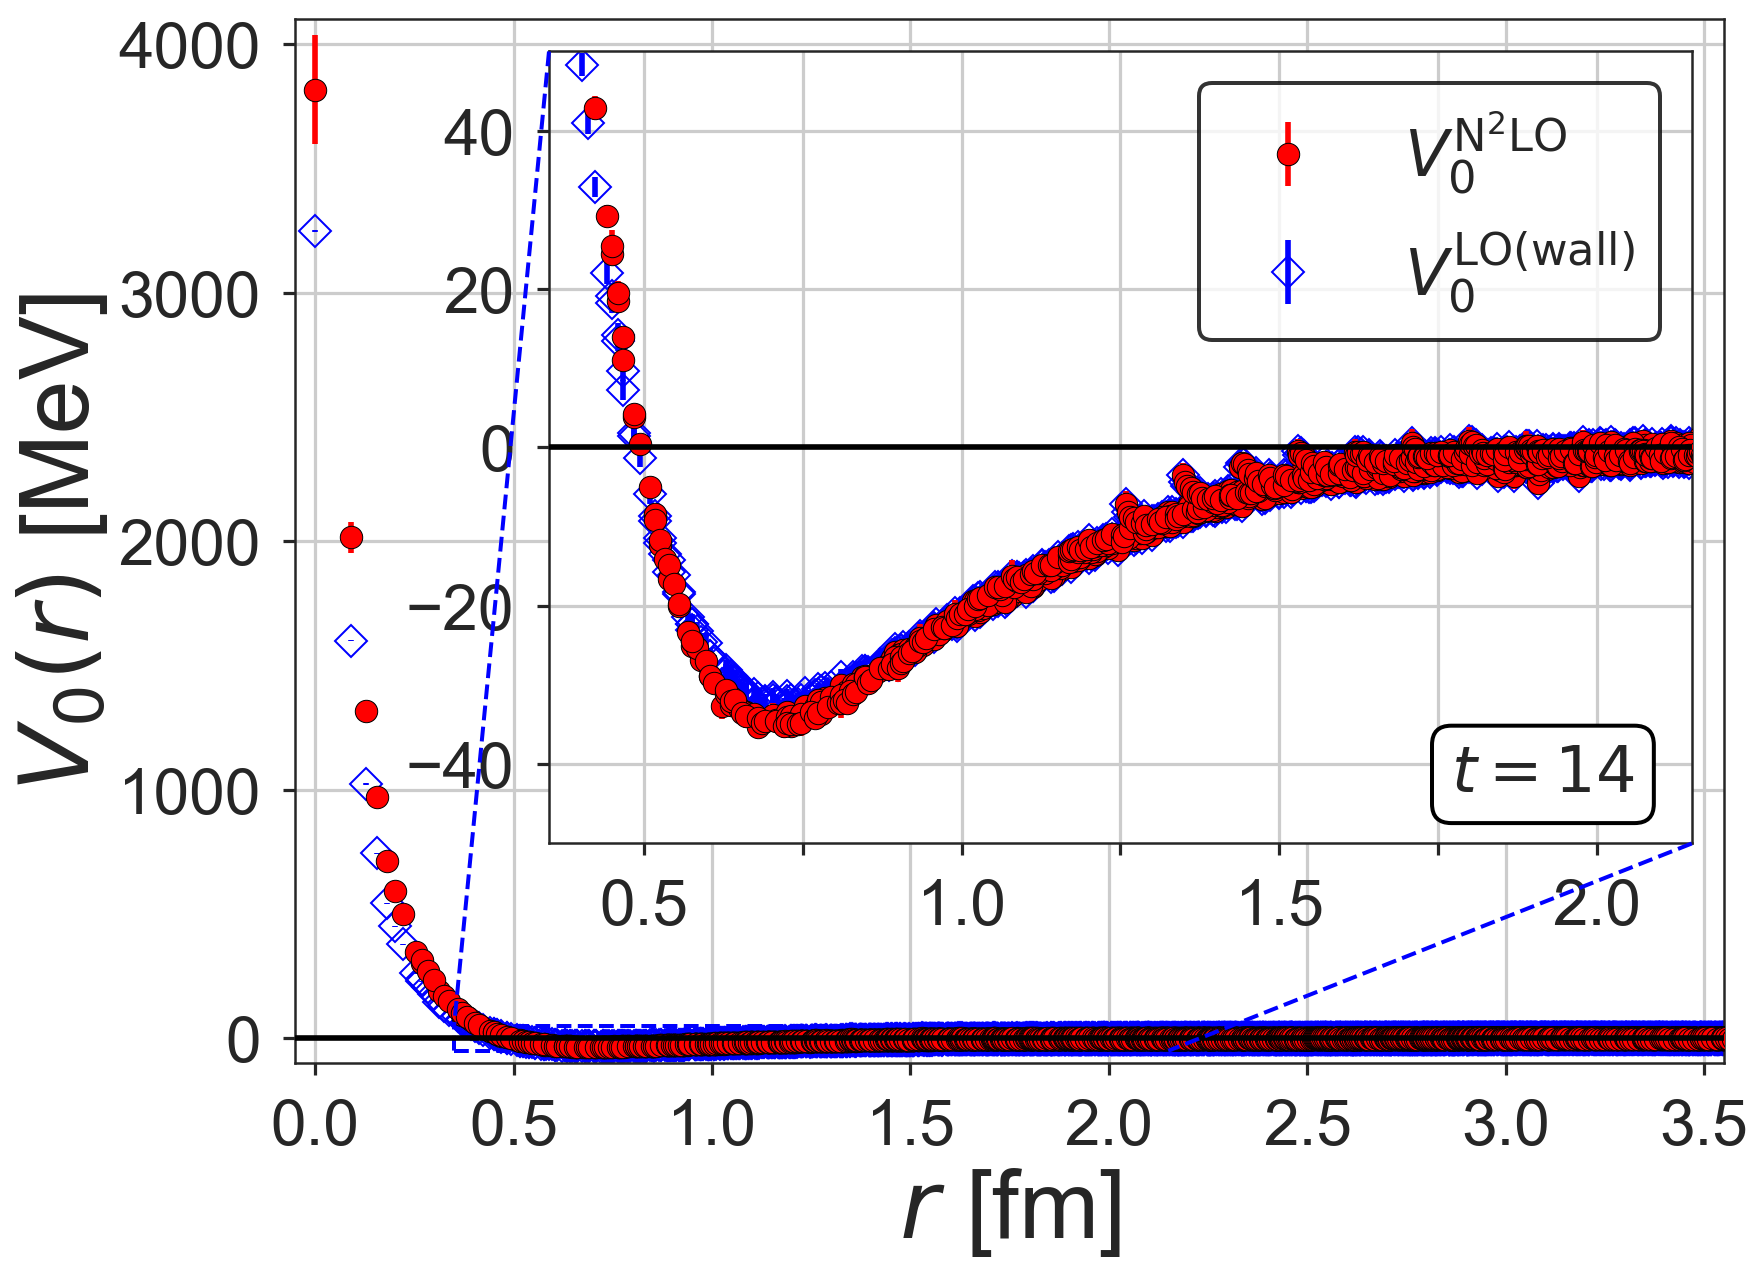

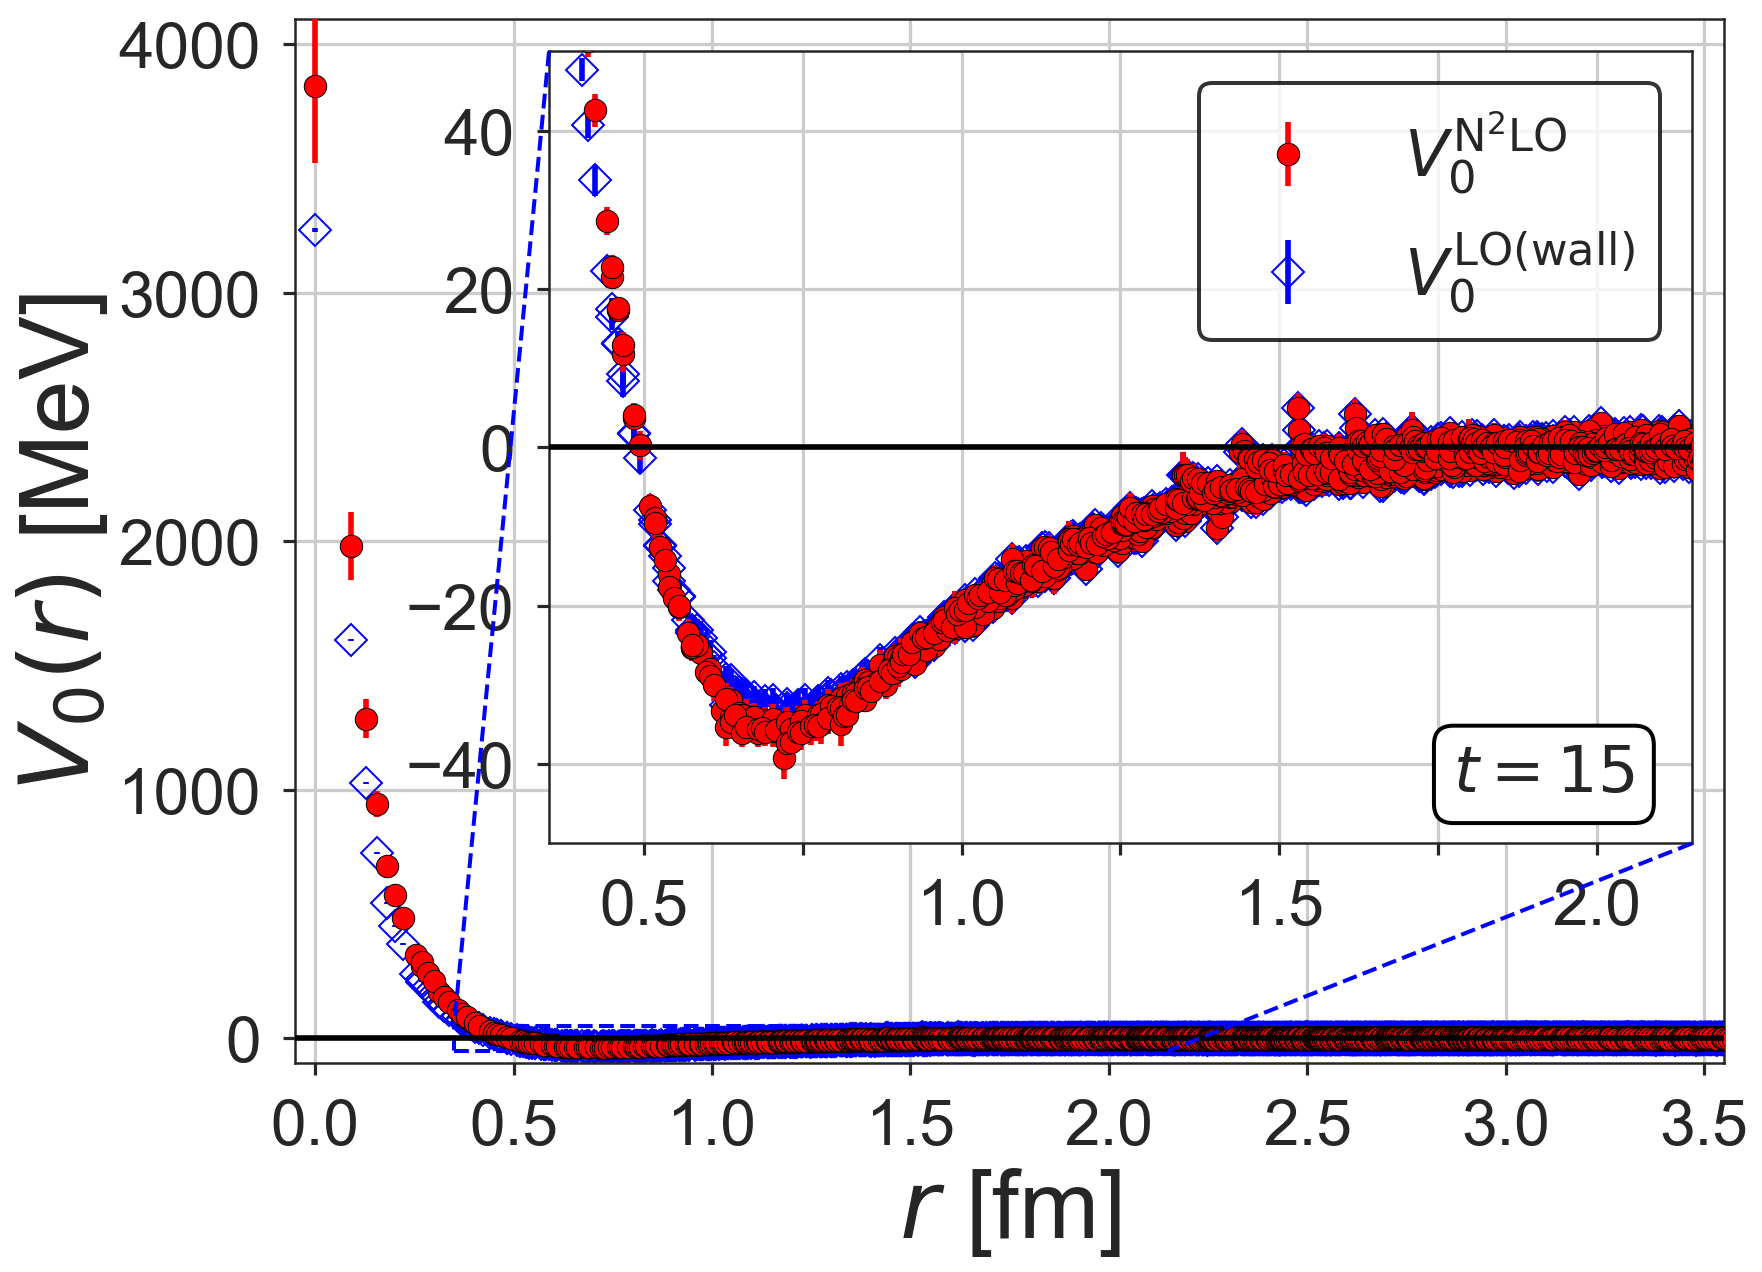

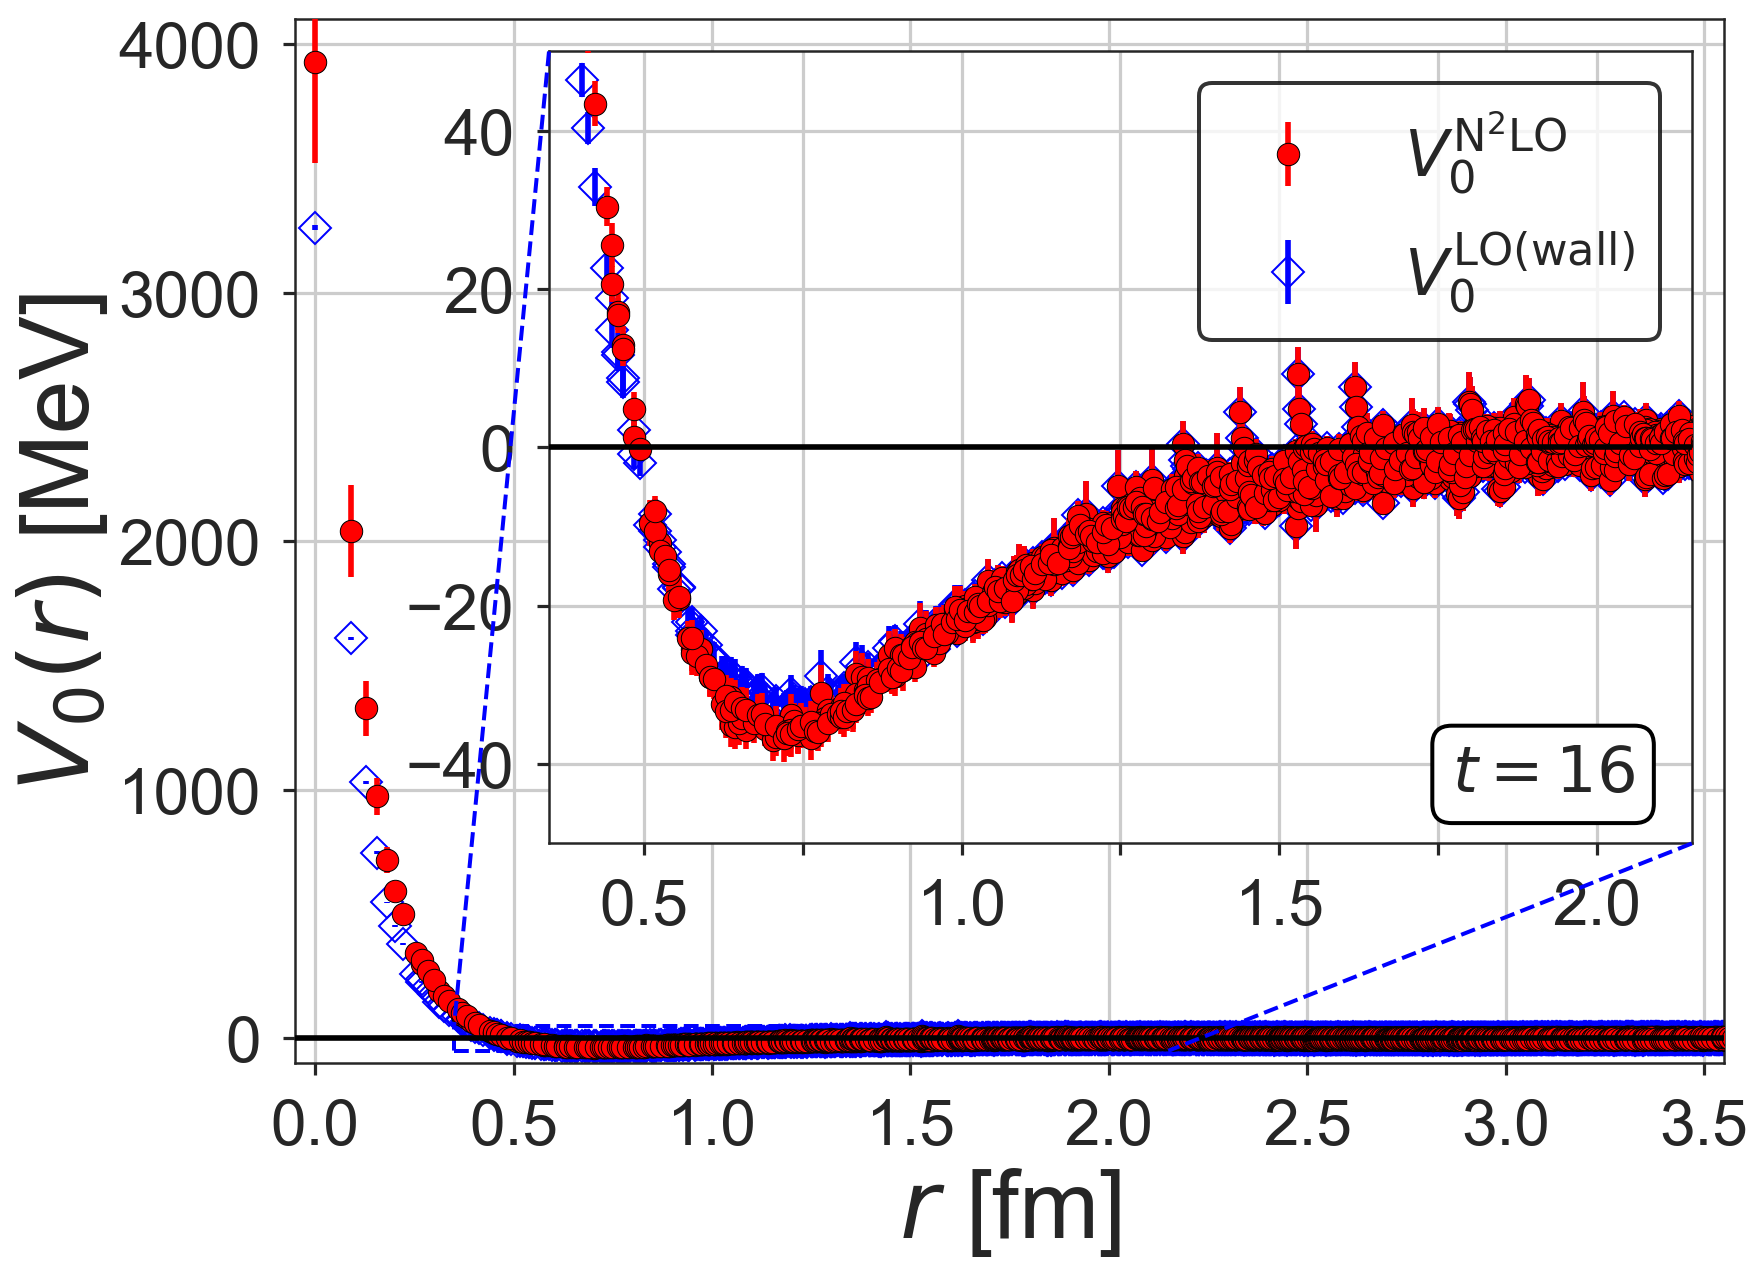

In [24]:
def plot_v0_pot(it):
    fig, ax = plt.subplots()
    
    v0_n2lo_av = V0_N2LO_jk[it].mean(axis=0)[a1_uniq]
    v0_n2lo_err = V0_N2LO_jk[it].std(axis=0)[a1_uniq] * np.sqrt(bin_num - 1)
    
    v0_wall_av = pot_jk_bin['wall'][it].mean(axis=0)
    v0_wall_err = pot_jk_bin['wall'][it].std(axis=0) * np.sqrt(bin_num - 1)
    
    ax.errorbar(lat_unit * rs, v0_n2lo_av * ainv, v0_n2lo_err * ainv,
                fmt='ro', zorder=3, mew=0.5, mec='black')

    ax.errorbar(lat_unit * rs, v0_wall_av * ainv, v0_wall_err * ainv,
                fmt='D', c='blue', mfc='none', mew=1.0, mec='blue', zorder=1)

    ax.axhline(0, color='black',zorder=5)
    xr = (-0.05, 3.55)
    ax.set_xlim(xr)
    ax.set_xticks([0,0.5,1.0,1.5, 2.0, 2.5, 3.0, 3.5])

    yr = (-100, 4100)
    ax.set_ylim(yr)
    ax.grid()
    ax.set_xlabel(r'$r$ [fm]', fontsize=48)
    ax.set_ylabel(r'$V_0(r)$ [MeV]', fontsize=48)
    
    axins = inset_axes(ax, width='80%', height=5.5, loc=1)
    axins.errorbar(lat_unit * rs, v0_n2lo_av * ainv, v0_n2lo_err * ainv,
                   fmt='ro', label=r'$V_0^\mathrm{N^2LO}$', zorder=3, mew=0.5, mec='black')

    axins.errorbar(lat_unit * rs, v0_wall_av * ainv, v0_wall_err * ainv,
                fmt='D', c='blue', mfc='none', mew=1.0, mec='blue',
                label=r'$V_0^\mathrm{LO(wall)}$', zorder=1)
    axins.set_xlim(0.35, 2.15)
    axins.set_xticks([0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0])
    axins.set_xticklabels([0.5, '', 1.0, '', 1.5, '', 2.0])
    axins.set_ylim(-50, 50)
    axins.axhline(0, c='black', zorder=5)
    axins.grid()

    props = dict(boxstyle='round', facecolor='white', linewidth=2, alpha=1.0)
    xr = axins.get_xlim()
    yr = axins.get_ylim()
    axins.text(xr[0]+0.95*(xr[1]-xr[0]), yr[0] + 0.05*(yr[1]-yr[0]), 
               rf'$t = {it}$', fontsize=32, bbox=props,
               horizontalalignment='right',
               verticalalignment='bottom')

    leg = axins.legend(loc='upper right', frameon=True, fontsize=32)
    leg.get_frame().set_edgecolor('black')
    leg.get_frame().set_linewidth(2.0)
    mark_inset(ax, axins, loc1=2, loc2=4, ls='--', lw=2, ec='blue', zorder=3)
    fig.savefig(f'../figs/pot_N2LO/pot_v0_n2lo_t{it}_w_zoom.png', bbox_inches='tight')
    
for it in [13, 14, 15, 16]:
    plot_v0_pot(it)

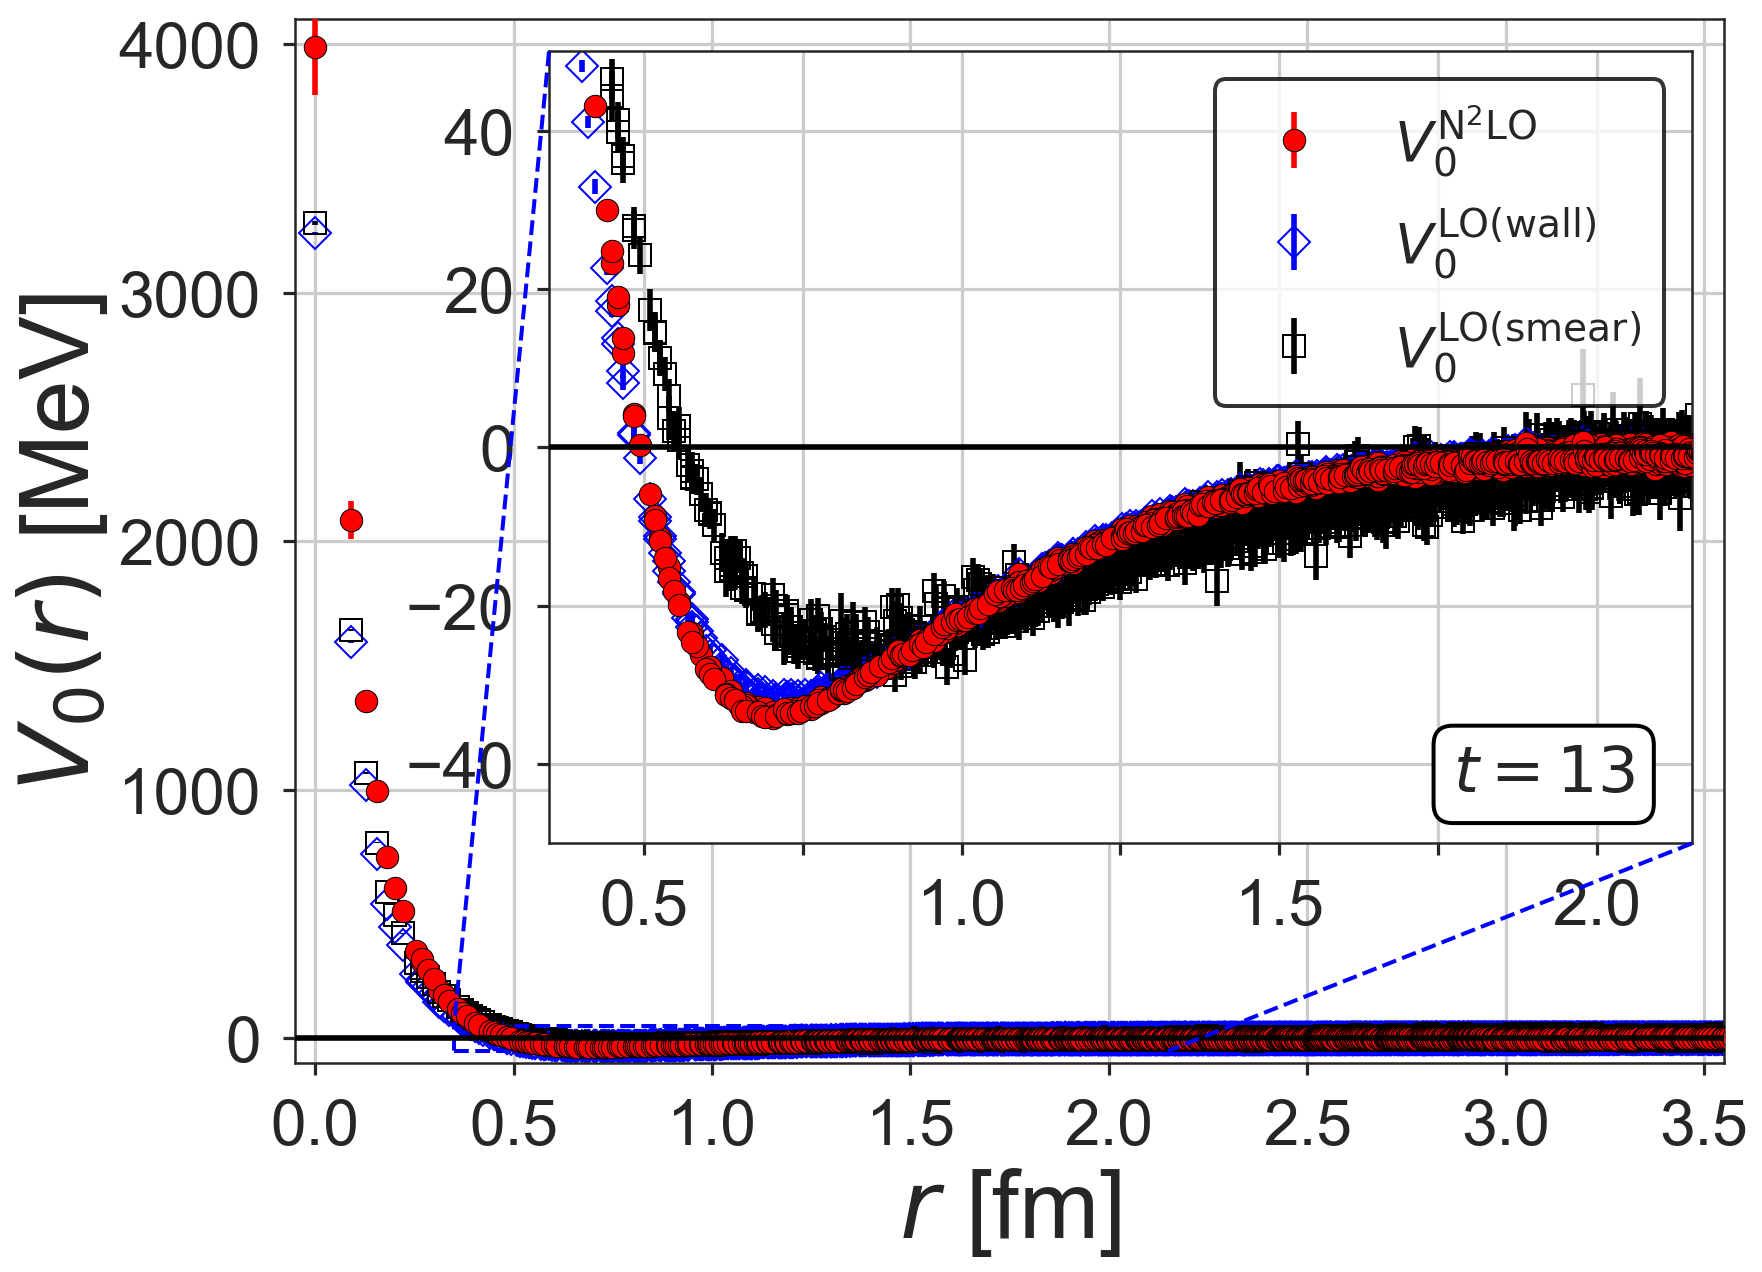

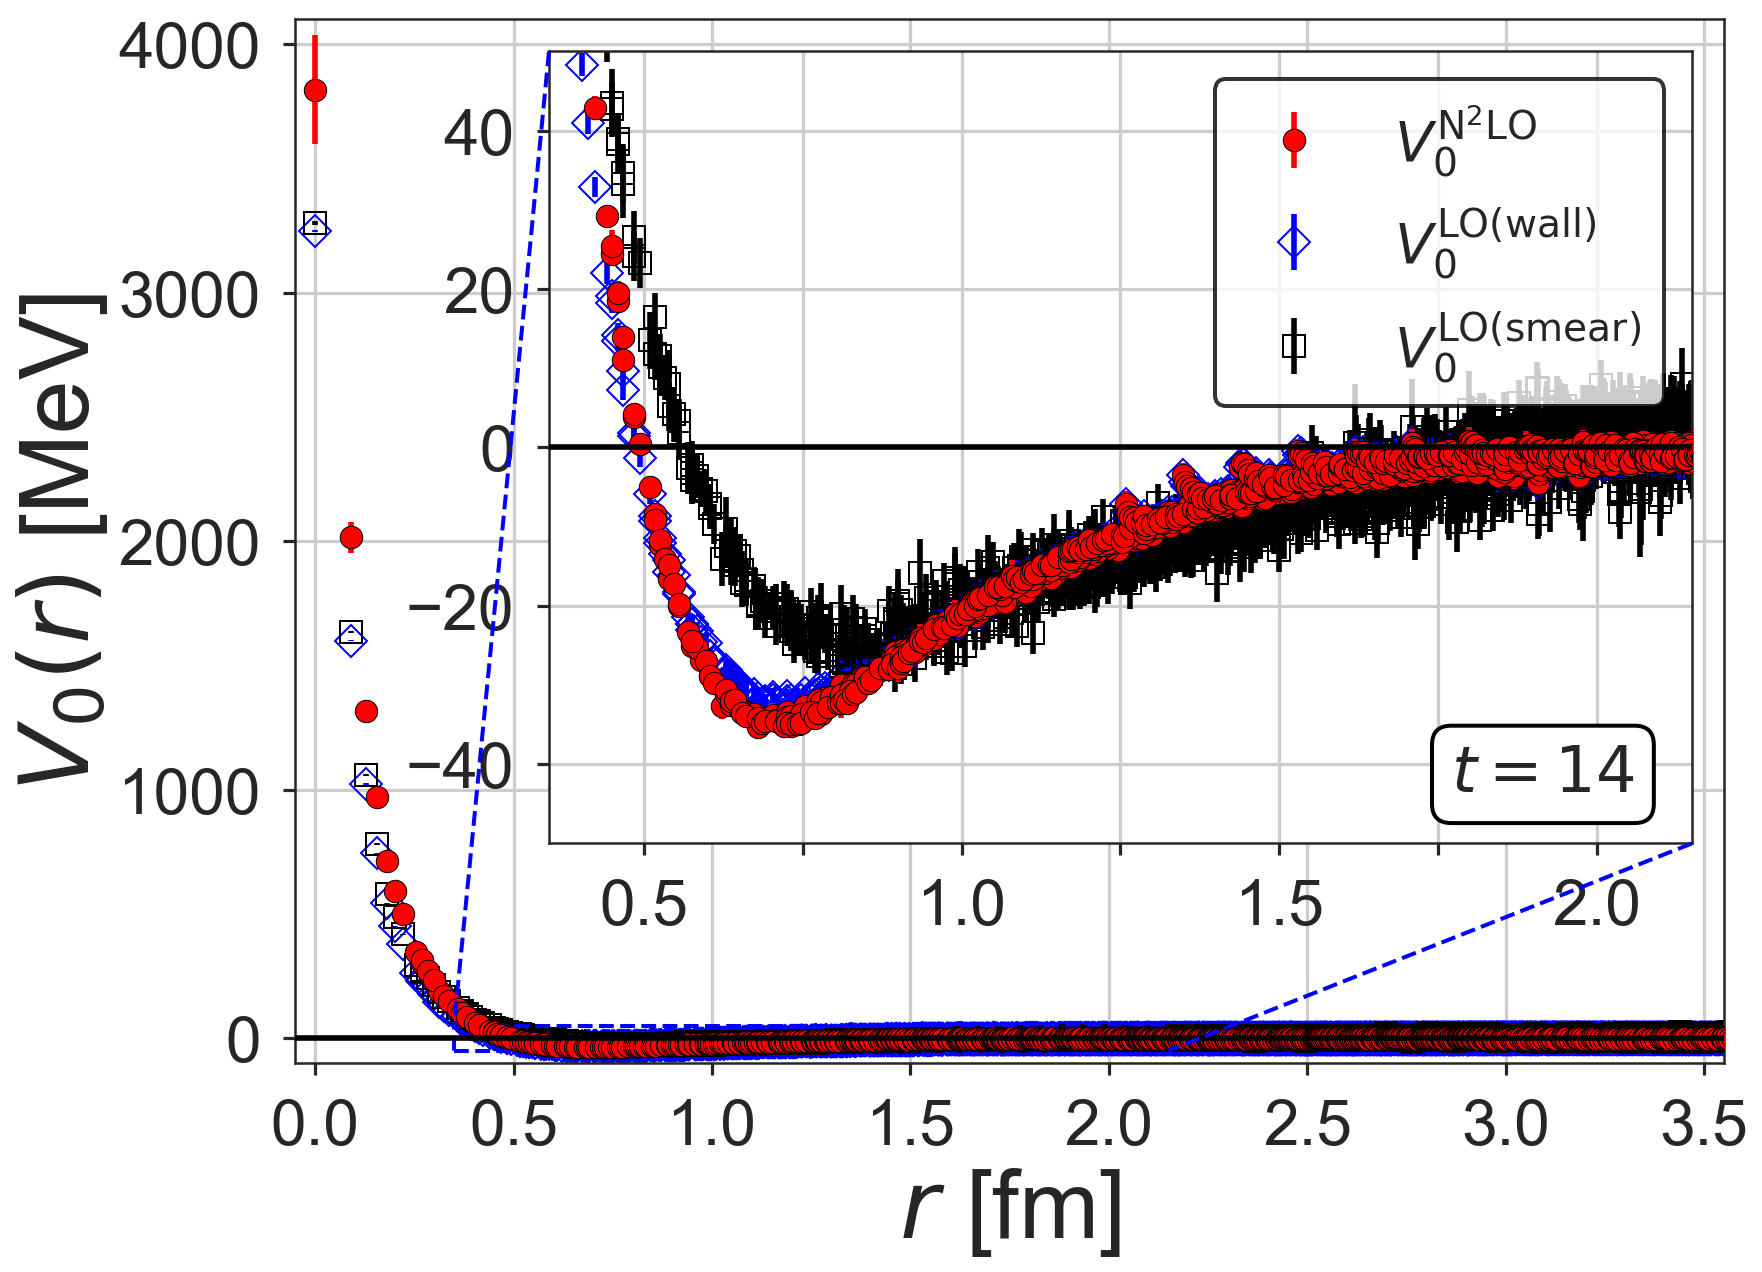

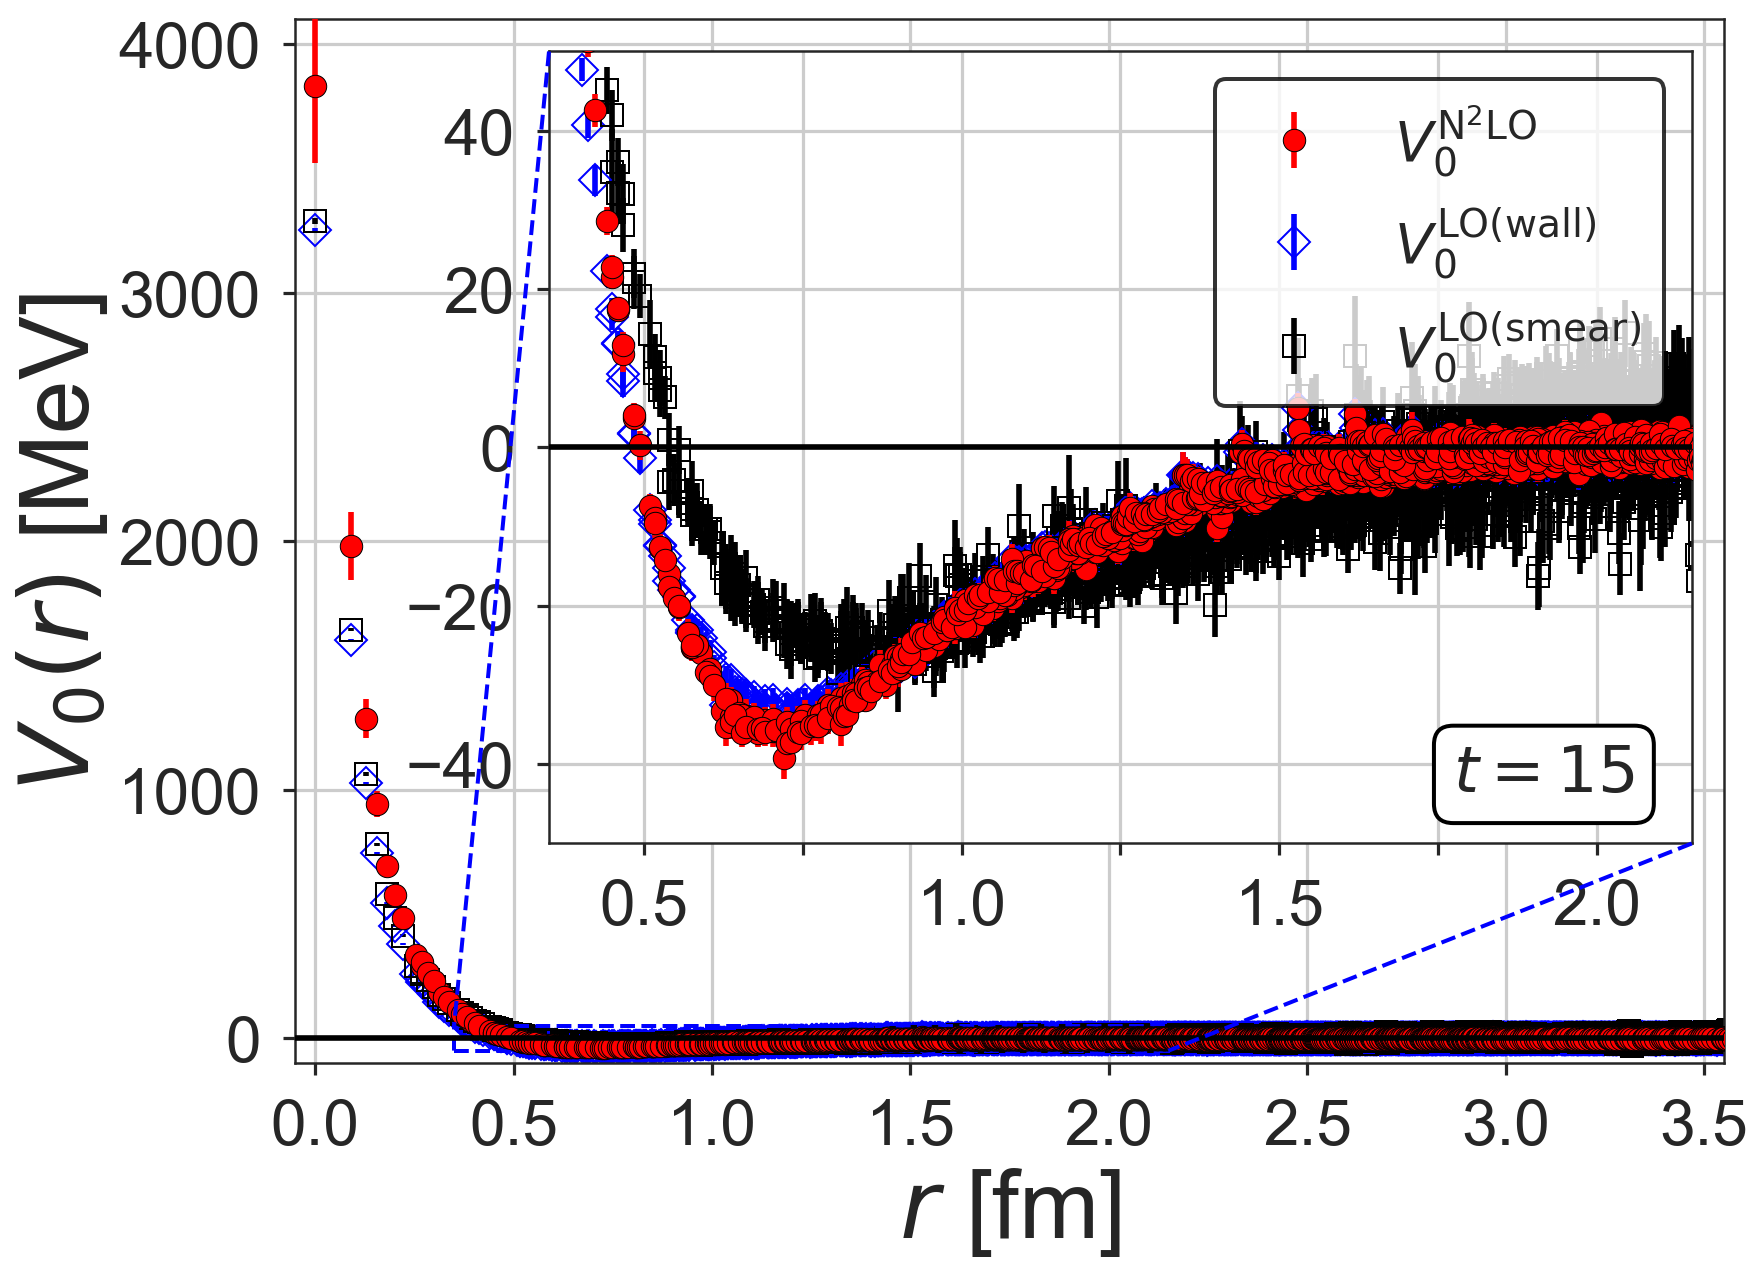

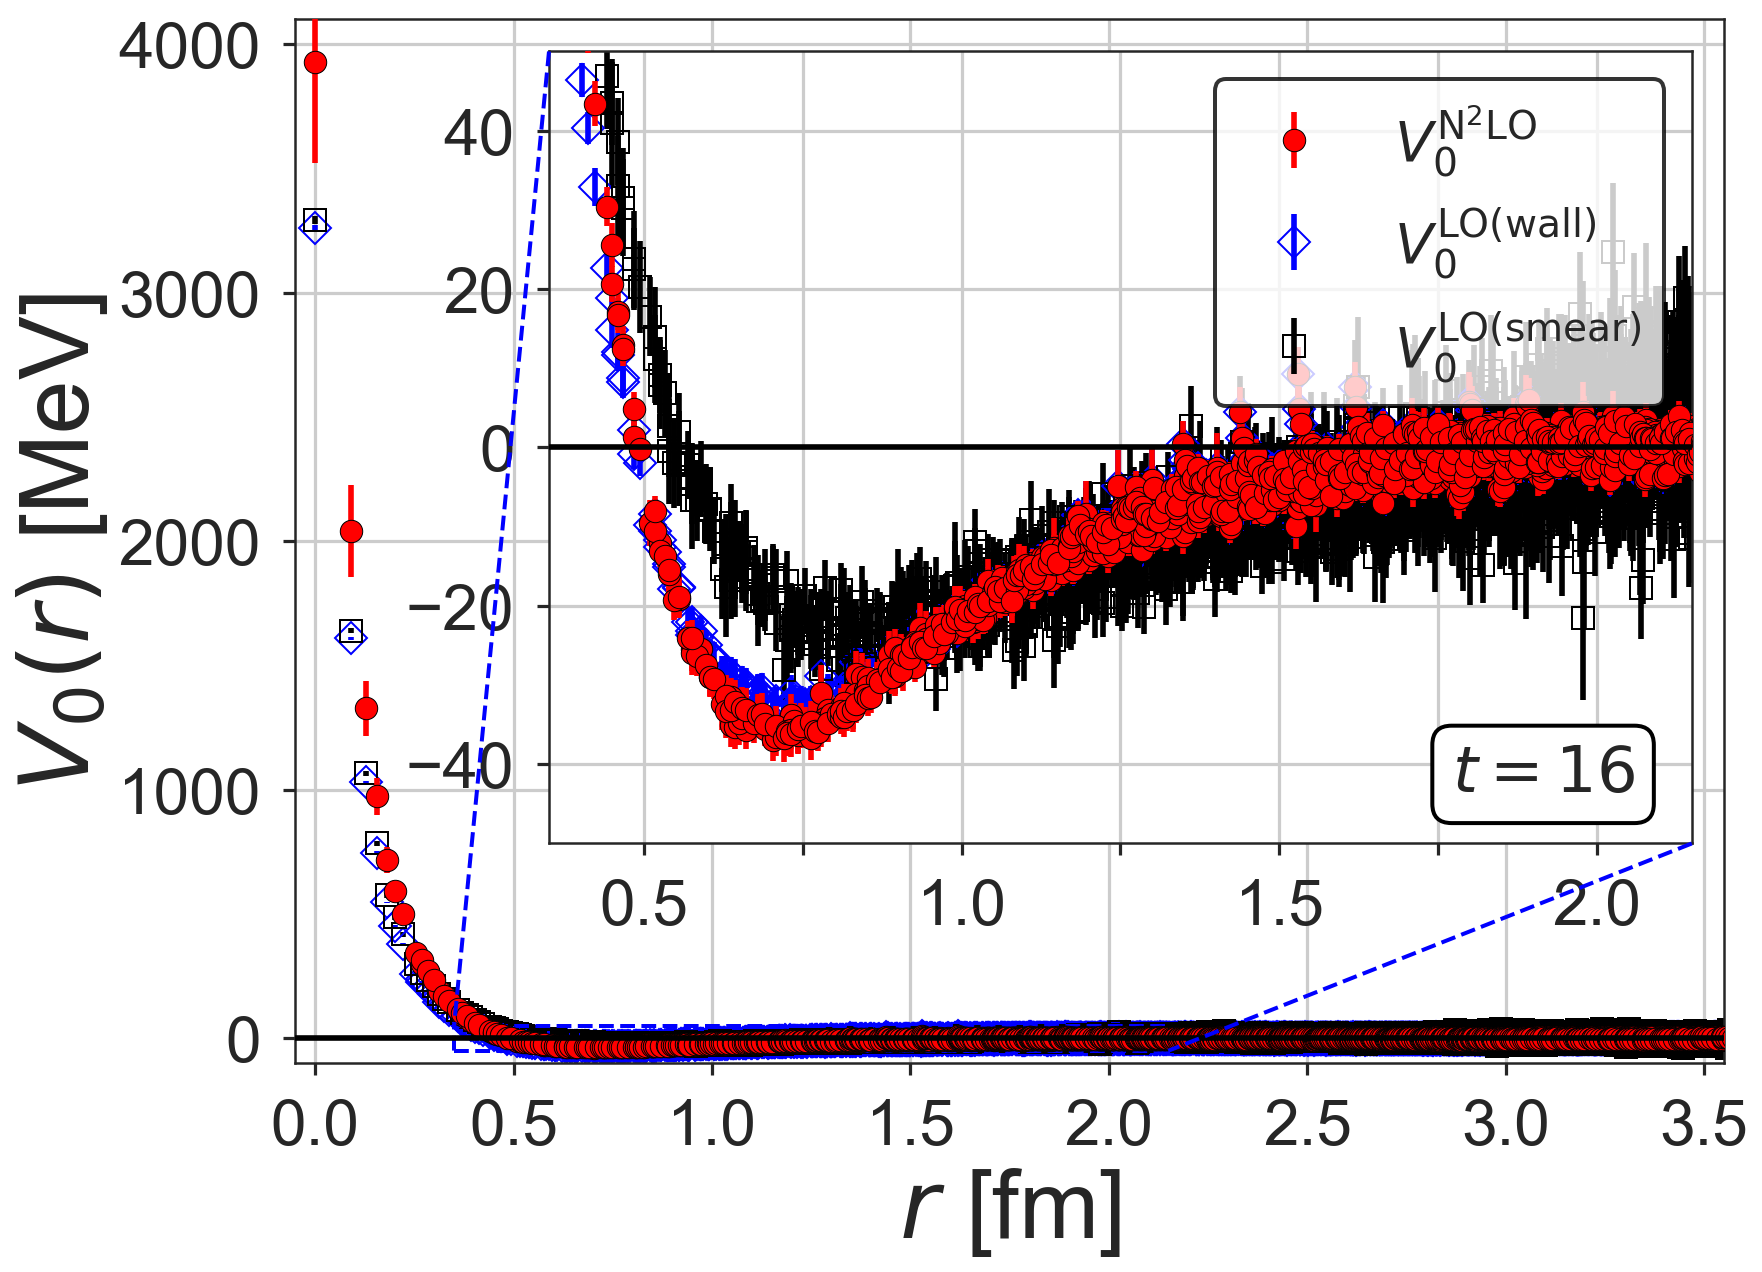

In [25]:
def plot_v0_pot_w_smear(it):
    fig, ax = plt.subplots()
    
    v0_n2lo_av = V0_N2LO_jk[it].mean(axis=0)[a1_uniq]
    v0_n2lo_err = V0_N2LO_jk[it].std(axis=0)[a1_uniq] * np.sqrt(bin_num - 1)
    
    v0_wall_av = pot_jk_bin['wall'][it].mean(axis=0)
    v0_wall_err = pot_jk_bin['wall'][it].std(axis=0) * np.sqrt(bin_num - 1)

    v0_exp_av = pot_jk_bin['exp'][it].mean(axis=0)
    v0_exp_err = pot_jk_bin['exp'][it].std(axis=0) * np.sqrt(bin_num - 1)

    ax.errorbar(lat_unit * rs, v0_n2lo_av * ainv, v0_n2lo_err * ainv,
                fmt='ro', zorder=3, mew=0.5, mec='black')

    ax.errorbar(lat_unit * rs, v0_wall_av * ainv, v0_wall_err * ainv,
                fmt='D', c='blue', mfc='none', mew=1.0, mec='blue', zorder=1)
    
    ax.errorbar(lat_unit * rs, v0_exp_av * ainv, v0_exp_err * ainv,
                fmt='s', c='black', mfc='none', mew=1.0, mec='black', zorder=1)

    ax.axhline(0, color='black',zorder=5)
    xr = (-0.05, 3.55)
    ax.set_xlim(xr)
    ax.set_xticks([0,0.5,1.0,1.5, 2.0, 2.5, 3.0, 3.5])

    yr = (-100, 4100)
    ax.set_ylim(yr)
    ax.grid()
    ax.set_xlabel(r'$r$ [fm]', fontsize=48)
    ax.set_ylabel(r'$V_0(r)$ [MeV]', fontsize=48)
    
    axins = inset_axes(ax, width='80%', height=5.5, loc=1)
    axins.errorbar(lat_unit * rs, v0_n2lo_av * ainv, v0_n2lo_err * ainv,
                   fmt='ro', label=r'$V_0^\mathrm{N^2LO}$', zorder=3, mew=0.5, mec='black')

    axins.errorbar(lat_unit * rs, v0_wall_av * ainv, v0_wall_err * ainv,
                fmt='D', c='blue', mfc='none', mew=1.0, mec='blue',
                label=r'$V_0^\mathrm{LO(wall)}$', zorder=1)
    
    axins.errorbar(lat_unit * rs, v0_exp_av * ainv, v0_exp_err * ainv,
                fmt='ks', mfc='none', mew=1.0, mec='black', 
                   label=r'$V_0^\mathrm{LO(smear)}$', zorder=1)

    axins.set_xlim(0.35, 2.15)
    axins.set_xticks([0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0])
    axins.set_xticklabels([0.5, '', 1.0, '', 1.5, '', 2.0])
    axins.set_ylim(-50, 50)
    axins.axhline(0, c='black', zorder=5)
    axins.grid()

    props = dict(boxstyle='round', facecolor='white', linewidth=2, alpha=1.0)
    xr = axins.get_xlim()
    yr = axins.get_ylim()
    axins.text(xr[0]+0.95*(xr[1]-xr[0]), yr[0] + 0.05*(yr[1]-yr[0]), 
               rf'$t = {it}$', fontsize=32, bbox=props,
               horizontalalignment='right',
               verticalalignment='bottom')

    leg = axins.legend(loc='upper right', frameon=True, fontsize=28)
    leg.get_frame().set_edgecolor('black')
    leg.get_frame().set_linewidth(2.0)
    mark_inset(ax, axins, loc1=2, loc2=4, ls='--', lw=2, ec='blue', zorder=3)
    fig.savefig(f'../figs/pot_N2LO/pot_v0_lo_n2lo_t{it}.png', bbox_inches='tight')
    
for it in [13, 14, 15, 16]:
    plot_v0_pot_w_smear(it)

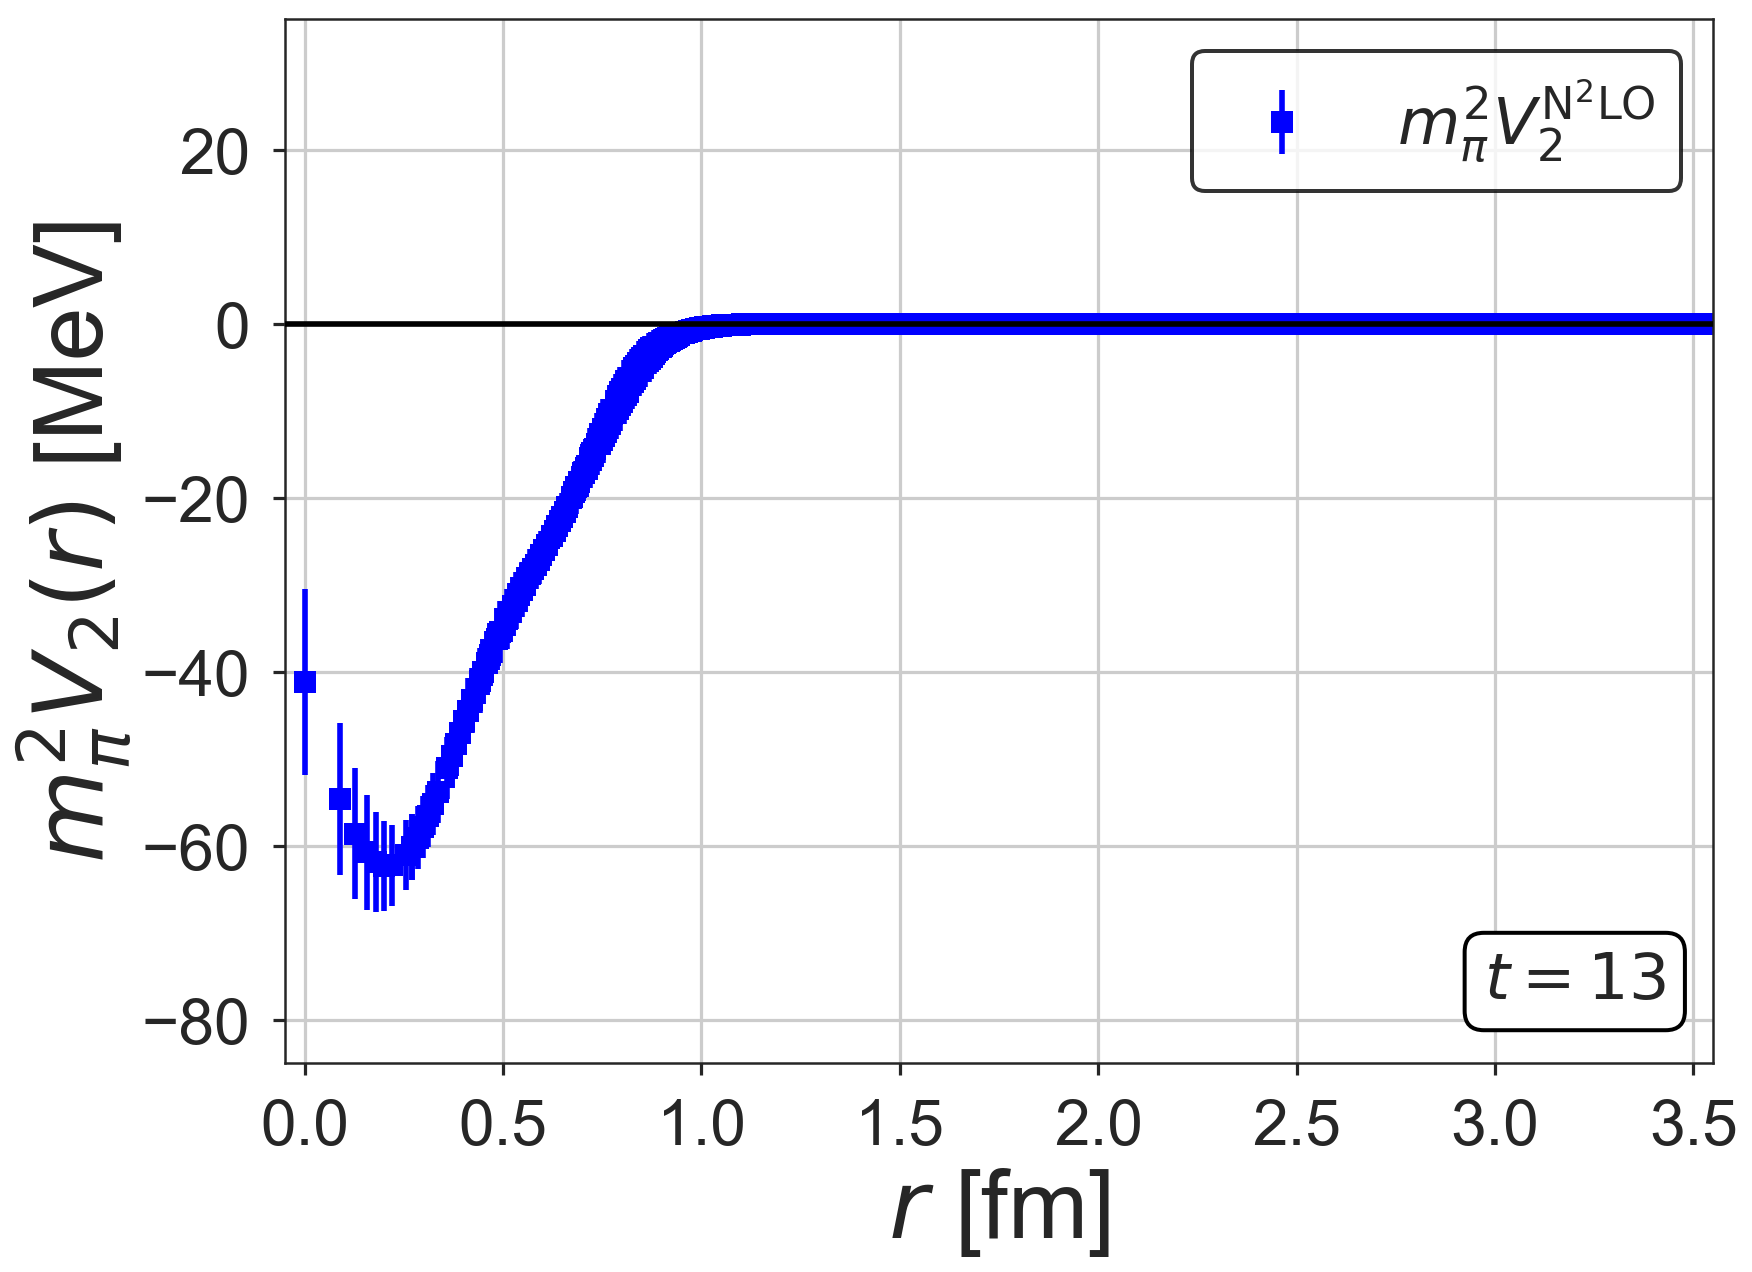

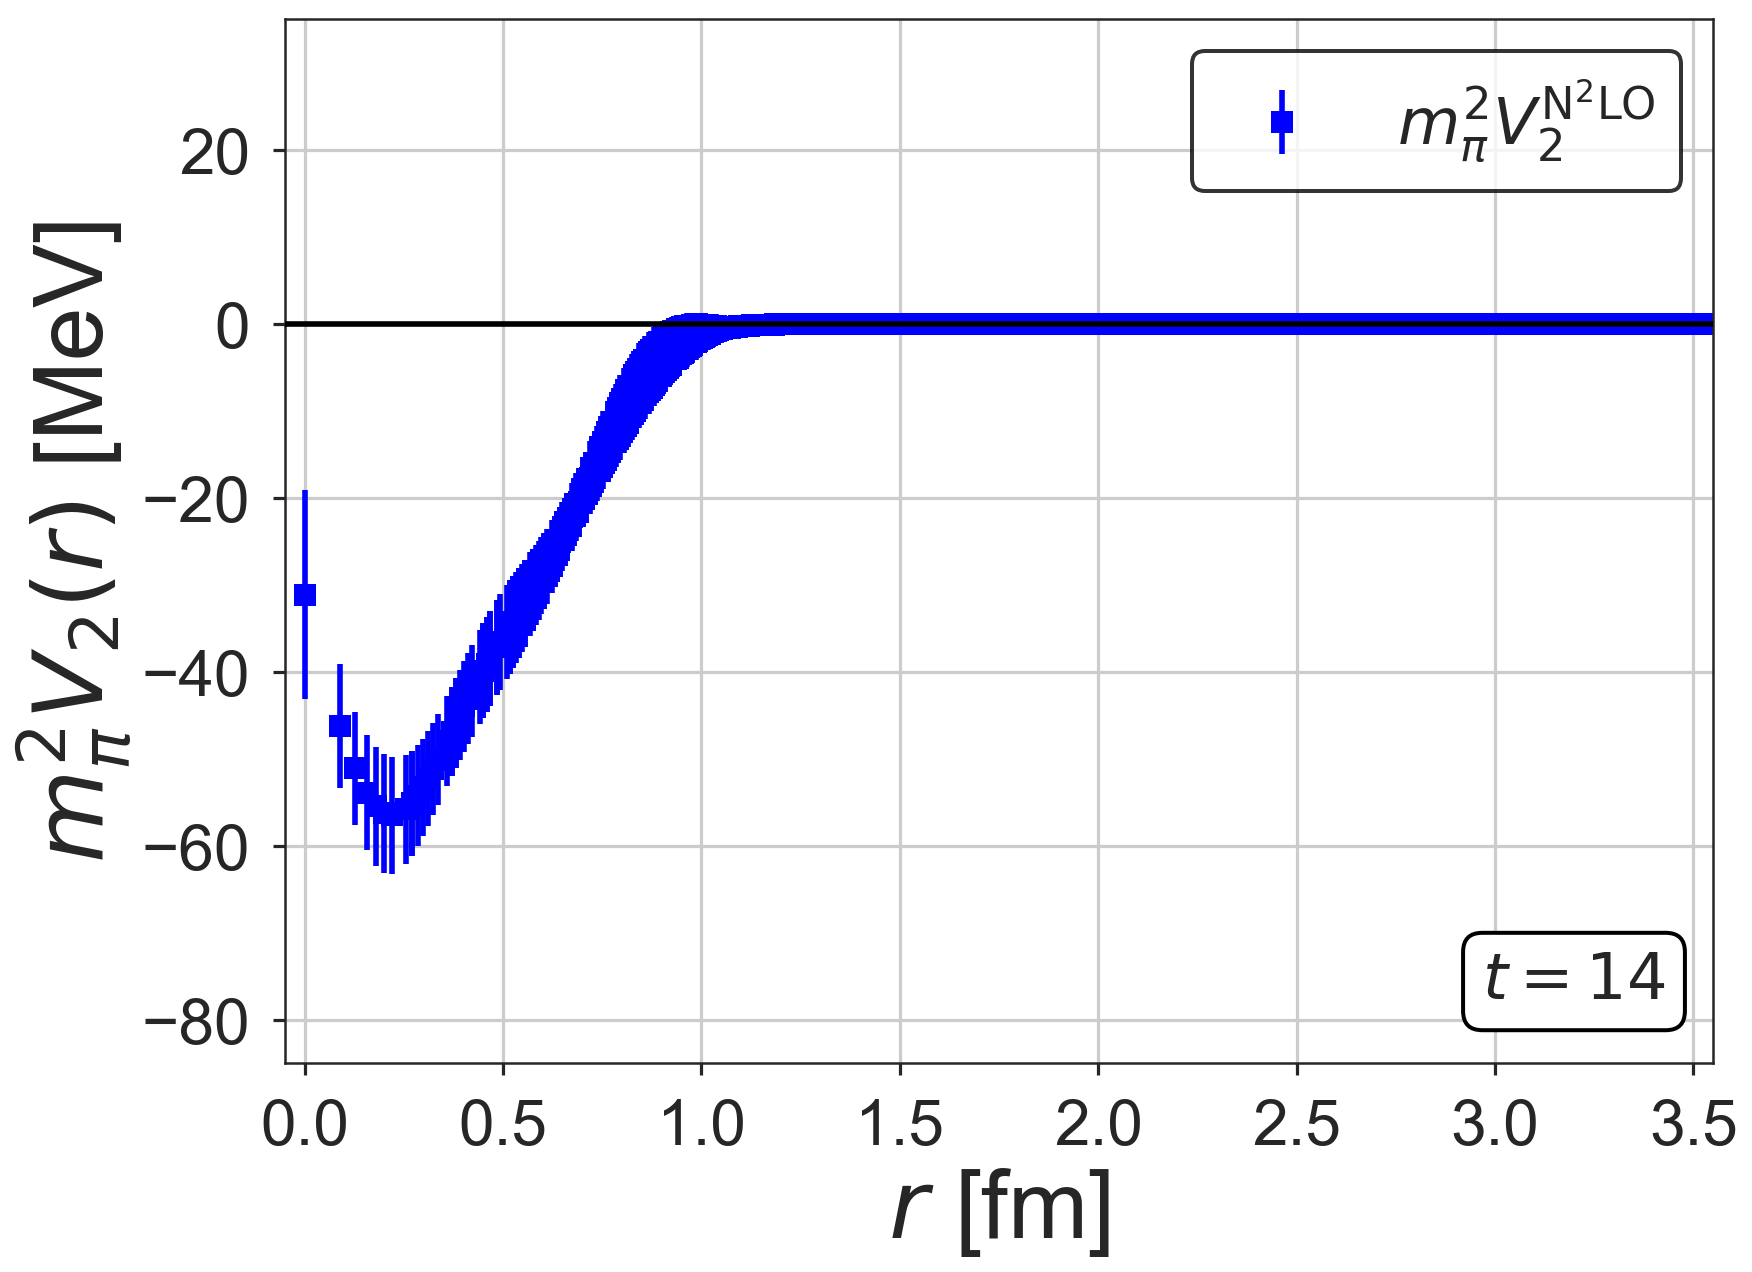

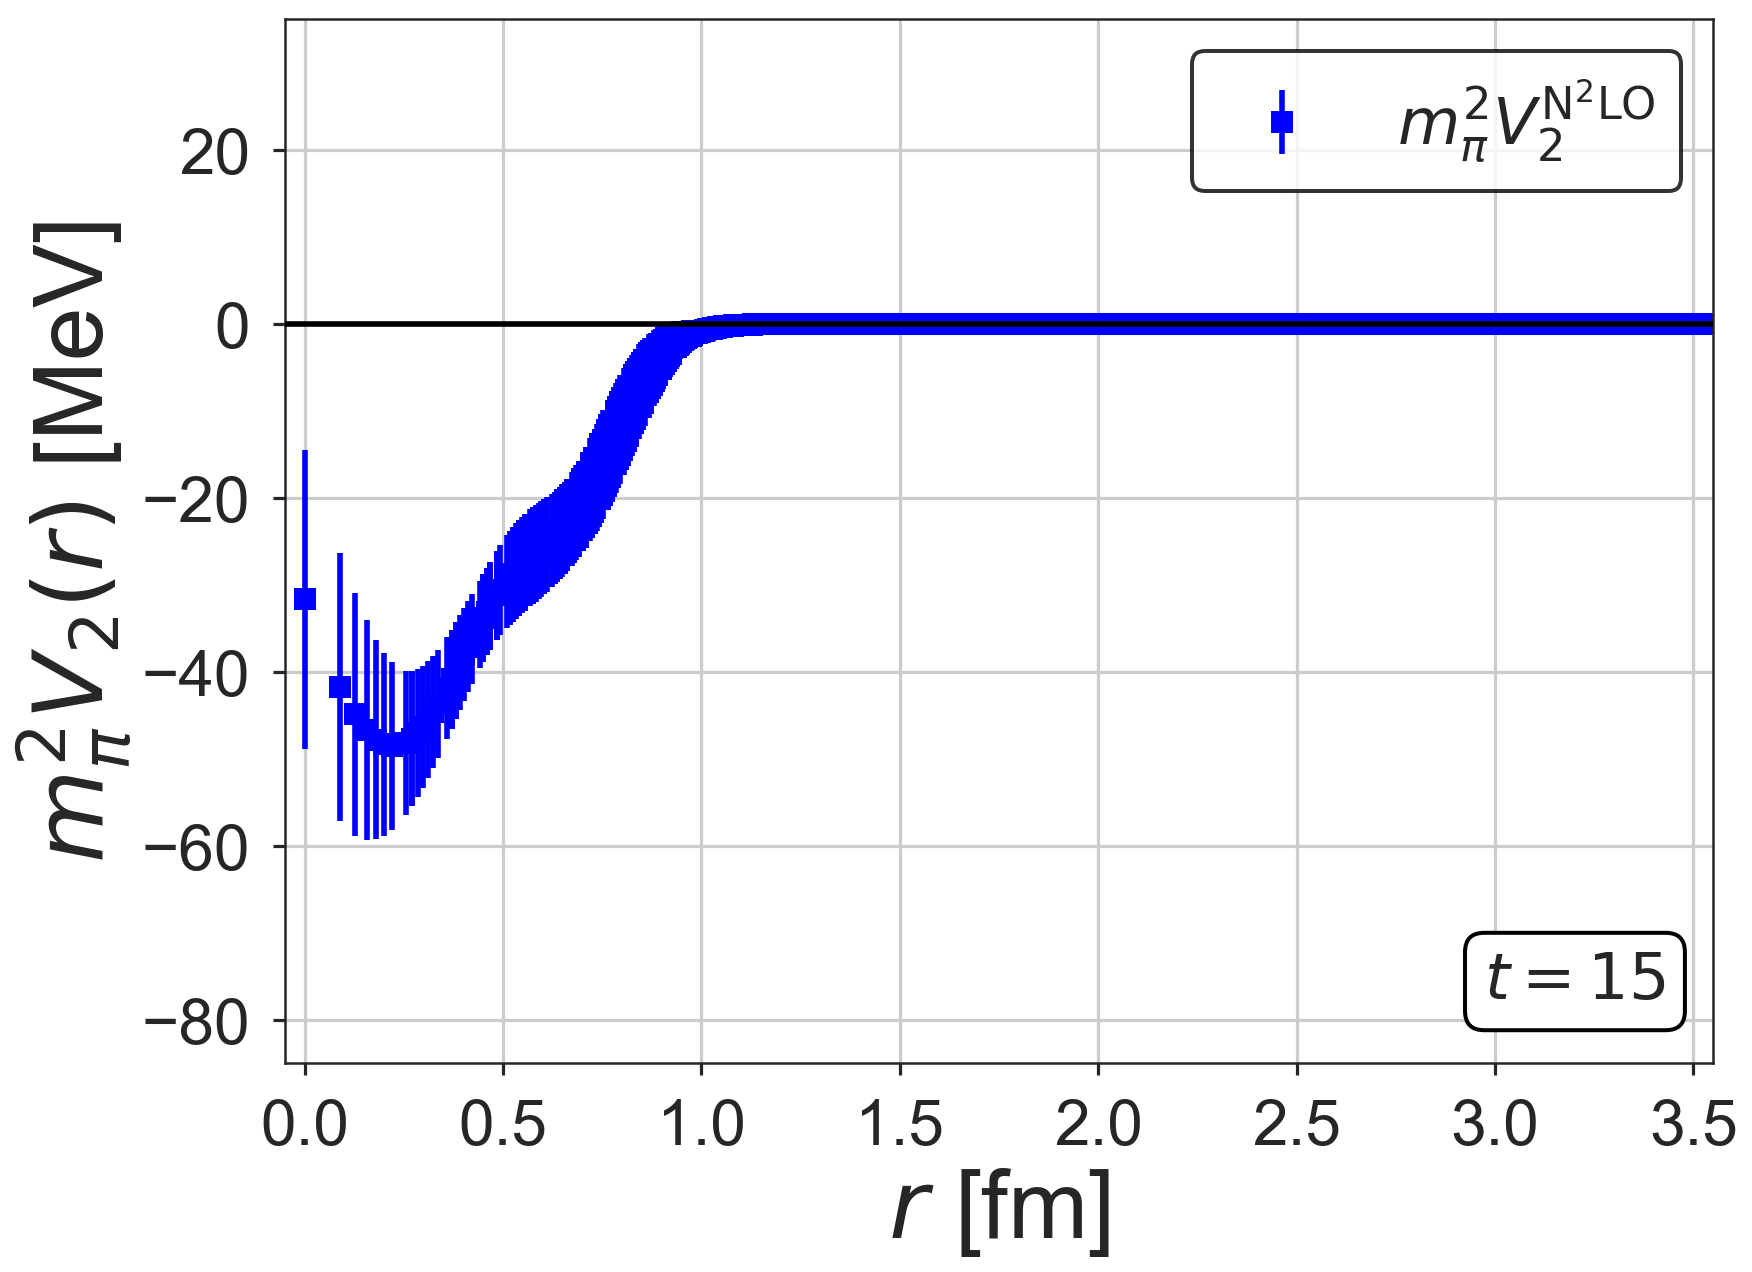

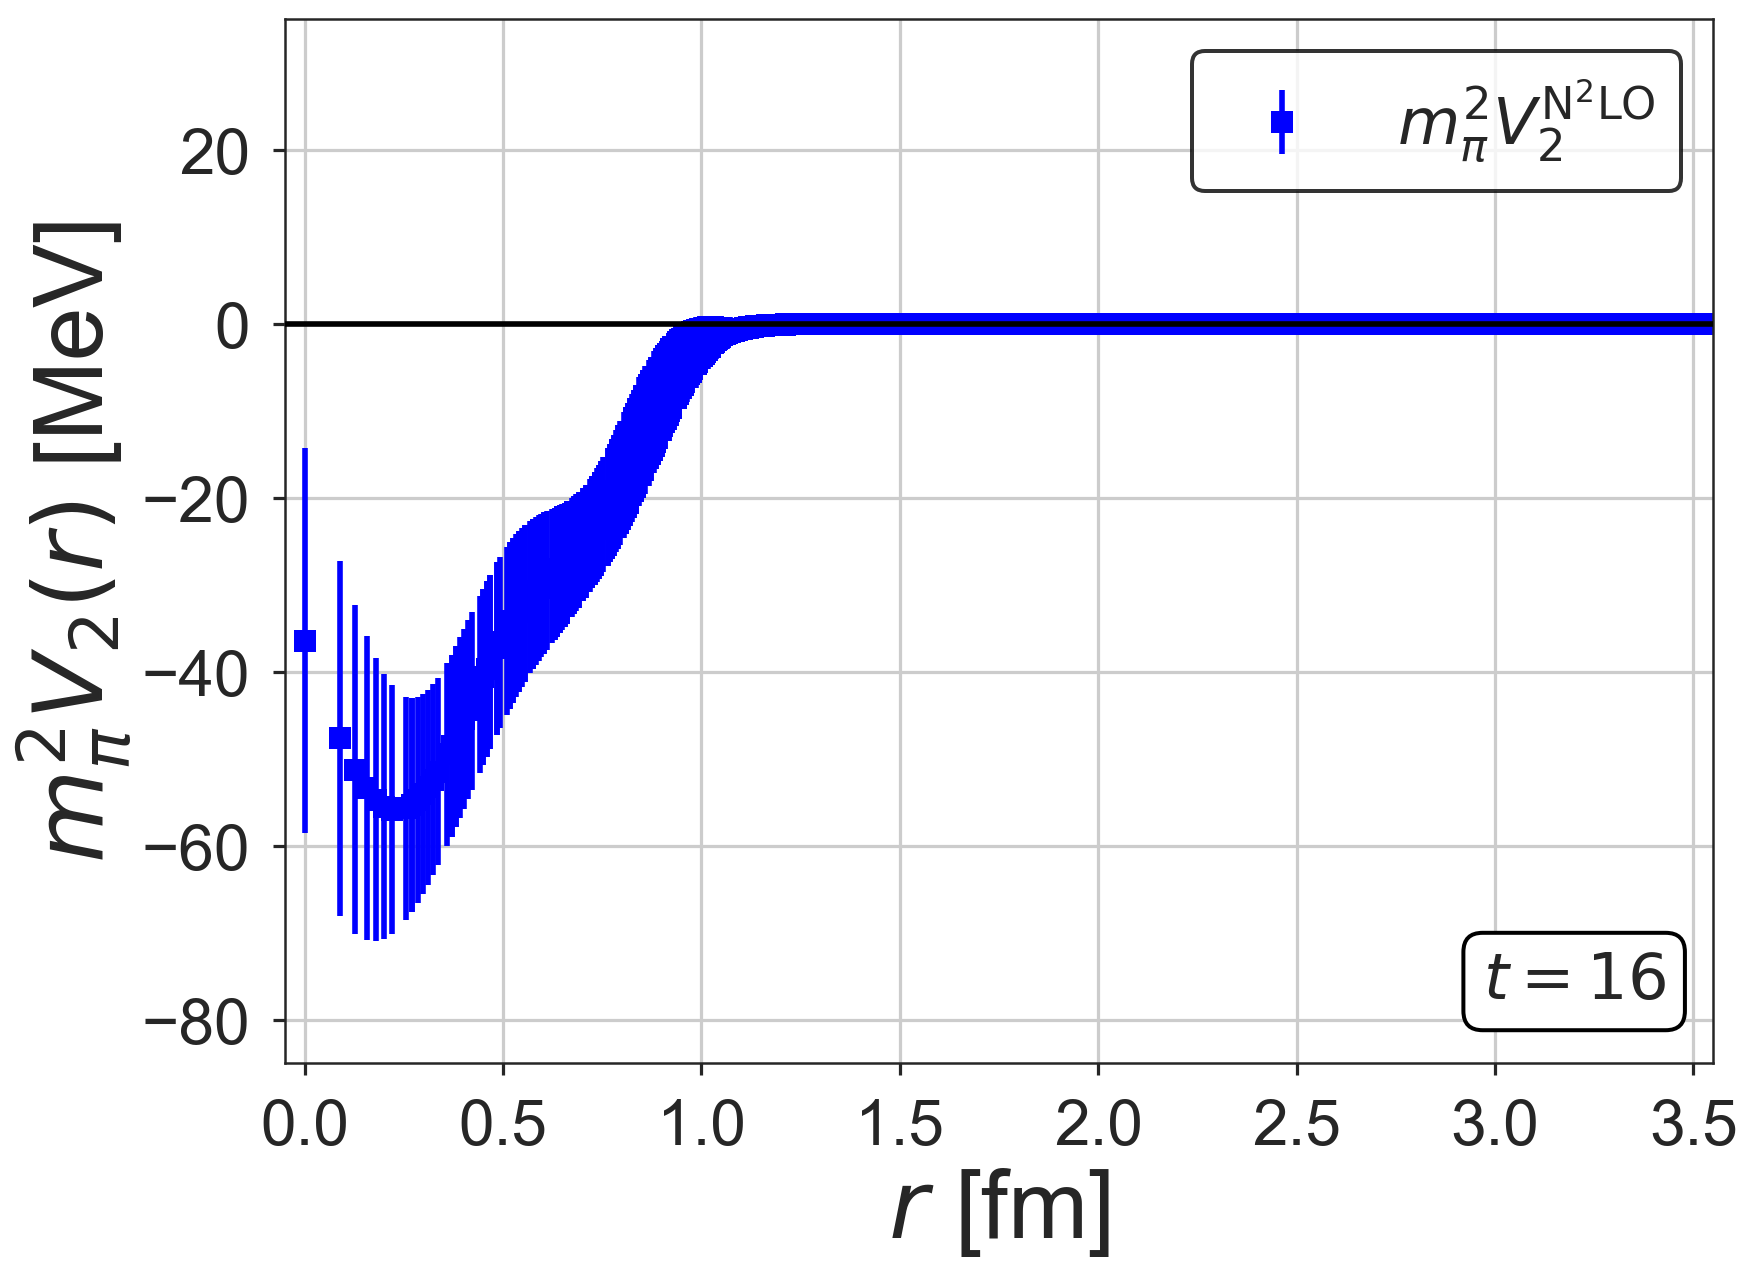

In [26]:
def plot_v2_n2lo(it):
    fig, ax = plt.subplots()

    ax.errorbar(lat_unit*rs, V2_N2LO_jk[it].mean(axis=0)[a1_uniq] *mpi**2*ainv, 
                V2_N2LO_jk[it].std(axis=0)[a1_uniq] * np.sqrt(bin_num - 1) * mpi**2*ainv,
               fmt='bs', label=r'$m_\pi^2V_2^\mathrm{N^2LO}$')

    xr = (-0.05, 3.55)
    yr = (-85, 35)
    ax.set_xlim(xr)
    ax.set_ylim(yr)
    ax.set_xticks([0,0.5,1.0,1.5, 2.0, 2.5, 3.0, 3.5])

    ax.grid()
    ax.set_xlabel(r'$r$ [fm]', fontsize=48)

    leg = ax.legend(loc='upper right', frameon=True, fontsize=32)
    leg.get_frame().set_edgecolor('black')
    leg.get_frame().set_linewidth(2.0)

    xr = (0, 3.5)
    props = dict(boxstyle='round', facecolor='white', linewidth=2, alpha=1.0)
    ax.text(xr[0]+0.98*(xr[1]-xr[0]), yr[0] + 0.05*(yr[1]-yr[0]), 
                   rf'$t = {it}$', fontsize=32, bbox=props,
                   horizontalalignment='right',
                   verticalalignment='bottom')


    ax.axhline(0, color='black',zorder=5)
    ax.set_xlabel(r'$r$ [fm]', fontsize=48)
    ax.set_ylabel(r'$m_\pi^2V_2(r)$ [MeV]', fontsize=48)
    fig.savefig(f'../figs/pot_N2LO/pot_v2_n2lo_t{it}.png', bbox_inches='tight')
    
for it in [13, 14, 15, 16]:
    plot_v2_n2lo(it)


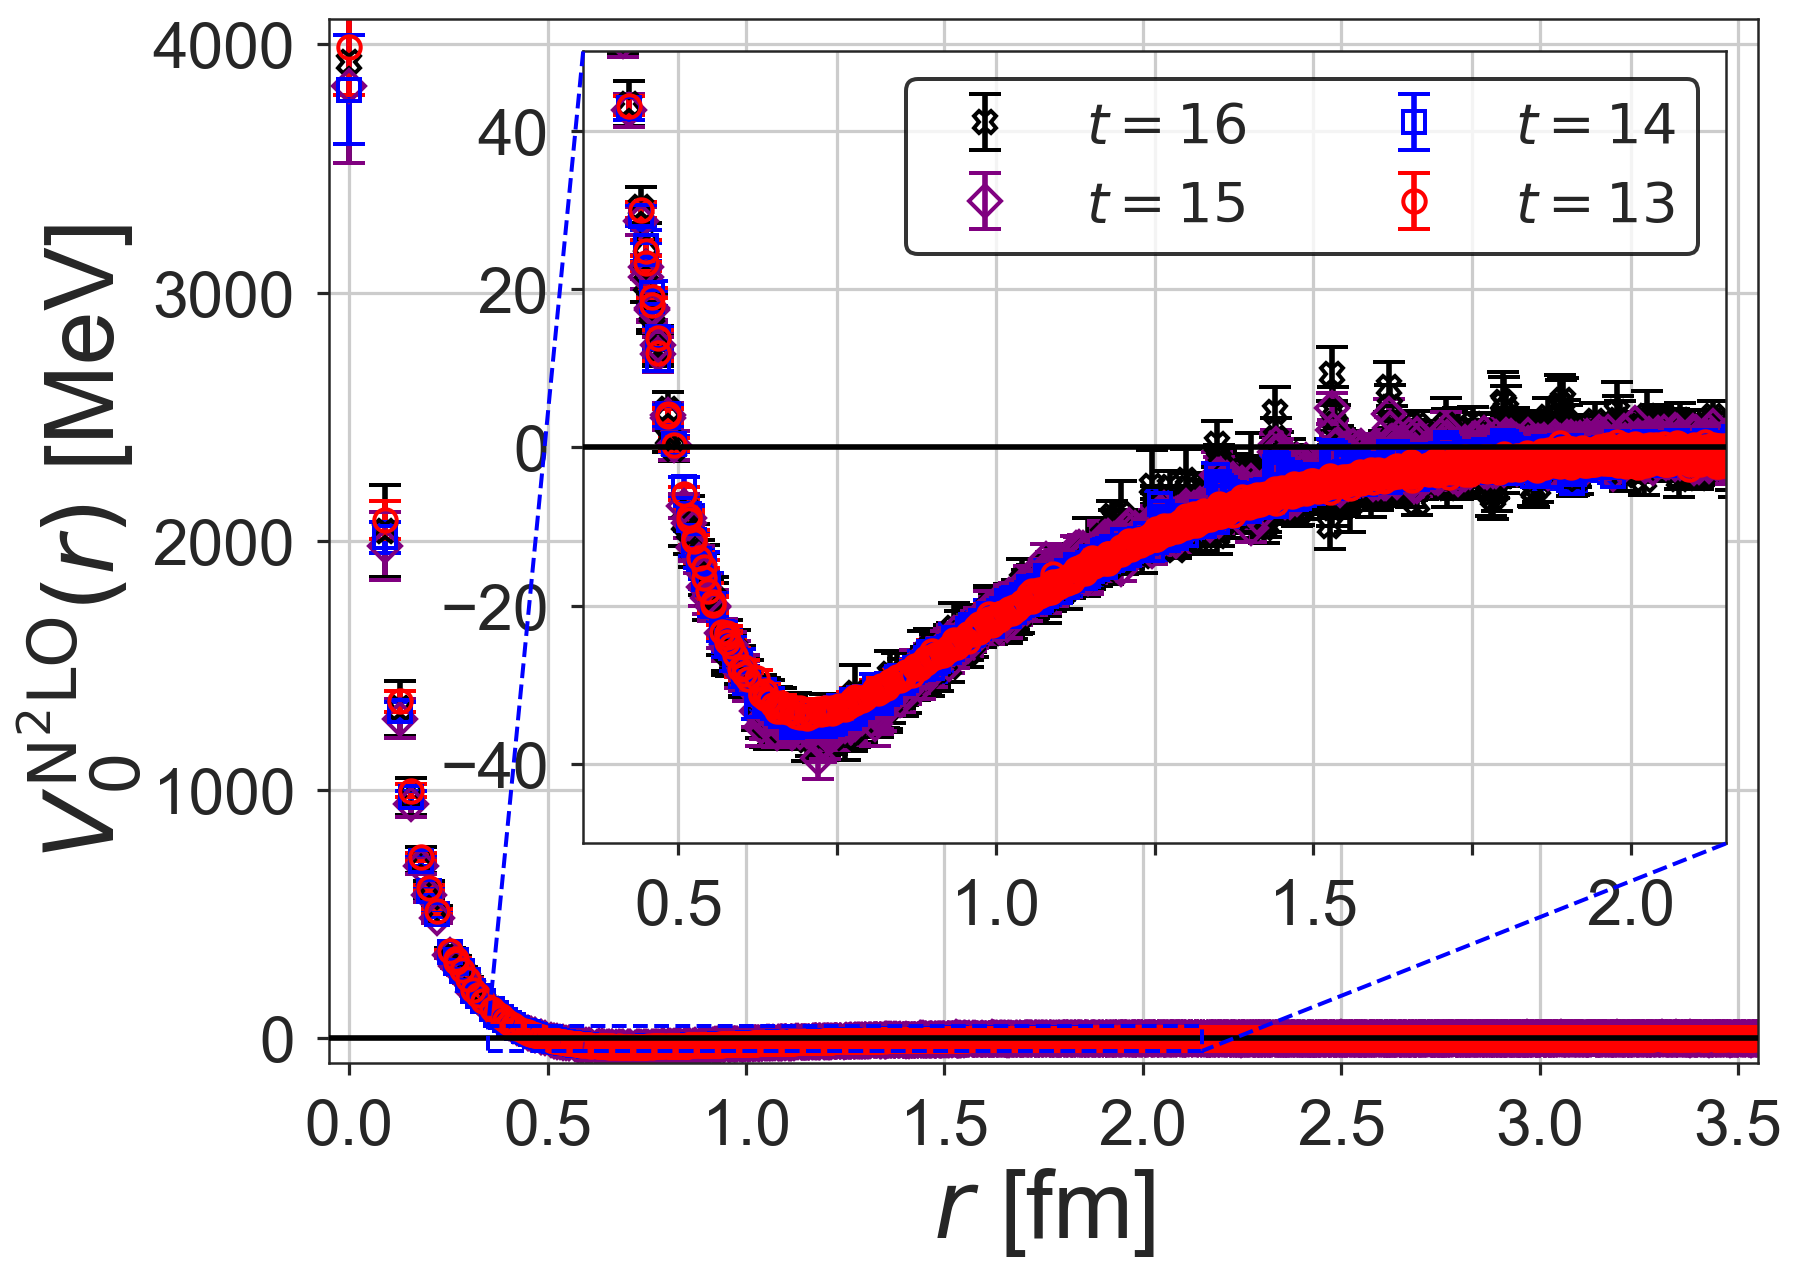

In [27]:
def plot_v0_n2lo_tdep():
    fig, ax = plt.subplots()
    
    for it, c, sym in zip([16, 15, 14, 13], ['black', 'purple', 'blue', 'red'],
                                             ['X', 'D', 's', 'o']):
        ax.errorbar(rs * lat_unit, 
                    V0_N2LO_jk[it].mean(axis=0)[a1_uniq] * ainv,
                    V0_N2LO_jk[it].std(axis=0)[a1_uniq] * np.sqrt(bin_num - 1) * ainv,
                    mfc='none', mew=2.0, mec=c, capsize=8, capthick=2.0, fmt=sym,c=c)
        
    ax.set_xlim(-0.05, 3.55)
    ax.set_xticks([0,0.5,1,1.5, 2.0, 2.5, 3, 3.5])
    ax.set_ylim(-100, 4100)
    ax.axhline(0, color='black', zorder=4)
    ax.grid()
    ax.set_xlabel(r'$r$ [fm]', fontsize=48)
    ax.set_ylabel(r'$V_0^\mathrm{N^2LO}(r)$ [MeV]', fontsize=48)
    
    axins = inset_axes(ax, width='80%', height=5.5, loc=1)
    for it, c, sym in zip([16, 15, 14, 13], ['black', 'purple', 'blue', 'red'],
                                             ['X', 'D', 's', 'o']):
        axins.errorbar(rs * lat_unit, 
                       V0_N2LO_jk[it].mean(axis=0)[a1_uniq] * ainv,
                       V0_N2LO_jk[it].std(axis=0)[a1_uniq]*np.sqrt(bin_num - 1) * ainv,
                    mfc='none', mew=2.0, mec=c, capsize=8, capthick=2.0, 
                    fmt=sym,c=c, label=r'$t = {}$'.format(it))

    axins.set_xlim(0.35, 2.15)
    axins.set_xticks([0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0])
    axins.set_xticklabels([0.5, '', 1.0, '', 1.5, '', 2.0])
    axins.set_ylim(-50, 50)
    axins.axhline(0, c='black', zorder=5)
    axins.grid()

    #ax.set_title('$L = 64$, $t = {}$'.format(it))
    leg = axins.legend(frameon=True, ncol=2, fontsize=28)
    leg.get_frame().set_edgecolor('black')
    leg.get_frame().set_linewidth(2.0)
    mark_inset(ax, axins, loc1=2, loc2=4, fc='none', ec='blue', ls='--', linewidth=2.0, zorder=5)

    fig.savefig('../figs/pot_N2LO/pot_v0_t_dep_L64.png', bbox_inches='tight')

plot_v0_n2lo_tdep()

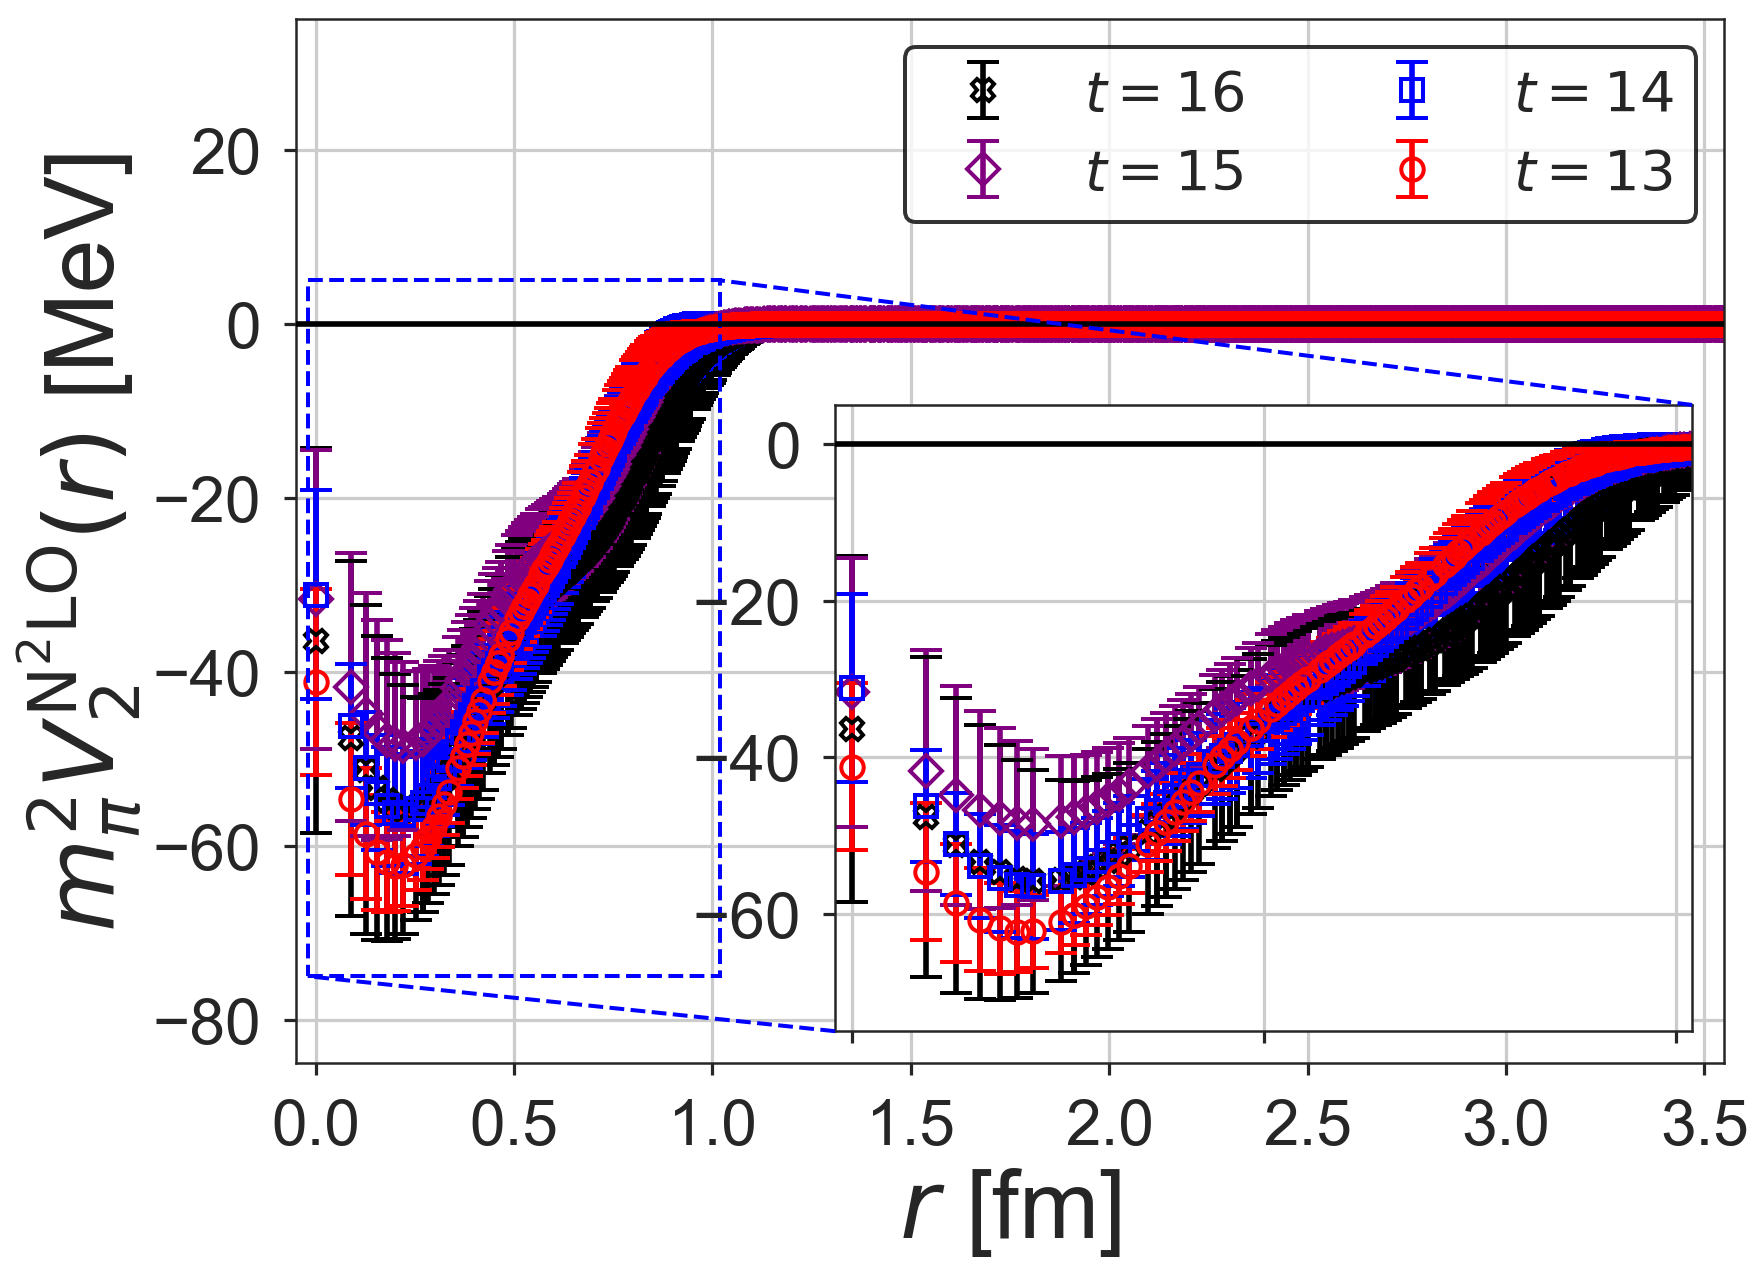

In [28]:
def plot_v2_tdep():
    fig, ax = plt.subplots()
    
    for it, c, sym in zip([16, 15, 14, 13], ['black', 'purple', 'blue', 'red'],
                                             ['X', 'D', 's', 'o']):
        ax.errorbar(rs * lat_unit, 
                    V2_N2LO_jk[it].mean(axis=0)[a1_uniq] * mpi**2 * ainv,
                    V2_N2LO_jk[it].std(axis=0)[a1_uniq]*np.sqrt(bin_num - 1) * mpi**2 * ainv,
                    fmt=sym, c=c, mfc='none',
                    mew=2.0, mec=c, capsize=8, capthick=2.0,
                    label=r'$t = {}$'.format(it))

                    
    
    axins = inset_axes(ax, width='60%', height='60%', loc=4)
    for it, c, sym in zip([16, 15, 14, 13], ['black', 'purple', 'blue', 'red'],
                                             ['X', 'D', 's', 'o']):
        axins.errorbar(rs * lat_unit, 
                      V2_N2LO_jk[it].mean(axis=0)[a1_uniq] * mpi**2 * ainv,
                      V2_N2LO_jk[it].std(axis=0)[a1_uniq]*np.sqrt(bin_num - 1) * mpi**2 * ainv,
                      fmt=sym, c=c, mfc='none',
                      mew=2.0, mec=c, capsize=8, capthick=2.0)

    axins.set_xlim(-0.02, 1.02)
    axins.set_xticklabels([])
    axins.set_xticks([0, 0.5, 1.0])
    axins.set_ylim(-75, 5)
    axins.axhline(0, c='black', zorder=5)
    axins.set_xticks([0, 0.5, 1.0])
    axins.grid()

    ax.set_xlim(-0.05, 3.55)
    ax.set_xticks([0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5])
    ax.set_ylim(-85, 35)
    ax.axhline(0, color='black', zorder=5)
    ax.set_xlabel(r'$r$ [fm]', size=48)
    ax.set_ylabel(r'$m_\pi^2 V_2^\mathrm{N^2LO}(r)$ [MeV]', size=48)
    ax.grid()
    leg = ax.legend(loc='upper right', frameon=True, ncol=2, fontsize=28)
    leg.get_frame().set_edgecolor('black')
    leg.get_frame().set_linewidth(2.0)
    mark_inset(ax, axins, loc1=1, loc2=3, fc='none', ec='blue', ls='--', linewidth=2.0, zorder=5)

    fig.savefig('../figs/pot_N2LO/pot_v2_t_dep_L64.png', bbox_inches='tight')

plot_v2_tdep()